In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import numpy as np
import time
import pickle
from statistics import mean


# Basic function

In [2]:
class data_formatter:
    '''
    Mainly Go and look at the folder and file list

    '''
    def __init__(self,path,Desired_param=False):
        self.path=path
        self.file_directory=[]
        self.Param=[]
        self.Param_pd=[]
        self.Par=[]
        self.Desired_param=Desired_param # wanted param such as pressue 1bar and offset 10mm
        self.Desired_file_directory=[] # Directory list based on wanted param
        self.contents=[] # Force or TCP , ANalogue => file set
        
        
    def file_searching(self,path):
        ## 1. Make file list
        file_lists=os.listdir(path)
        for file_list in file_lists:
            #print(file_list)
            # Only extract folder
            if os.path.isdir(os.path.join(path,file_list)): 
                self.file_directory.append(file_list)

        ## 2. Parameter list
        self.Param=[]
        for file in self.file_directory:
            self.Param.append(file.split('_'))
        self.Param_pd=pd.DataFrame(self.Param)

        k=0
        print("1st Folder name : ", self.file_directory[0])
        self.contents=os.listdir(os.path.join(self.path,file_list))
        print("Contents in the folder :", self.contents,"\n\n")
        for i in range(len(self.Param[1])):
            '''if len(self.Param_pd[i].unique())==1:
                print("**Variable**",self.Param_pd[i].unique(),"\n")
                V=self.Param_pd[i].unique()
            else:
                k=k+1
                print(k,"Parameters",self.Param_pd[i].unique(),"\n")
                self.Par.append(self.Param_pd[i].unique())'''
            k=k+1
            print(k,"Parameters",self.Param_pd[i].unique(),"\n")
            self.Par.append(self.Param_pd[i].unique())
            
    def desired_file_path(self,Desired_param):
        if len(self.Par) != len(Desired_param):
            print(f'Your input length ({len(self.Desired_param)}) does not match to Param length ({len(self.Par)})')
        else:
            #print('Go')
            for i in range(len(self.Par)):
                #print(i)
                #print((A.Par[i][input_param[i][:]]))
                if i ==0:
                    filt=self.Param_pd[i].isin(self.Par[i][self.Desired_param[i][:]])
                    #print(filt)
                else:
                    filt_temp=self.Param_pd[i].isin(self.Par[i][self.Desired_param[i][:]])
                    #print(filt_temp)
                    filt=filt_temp&filt
                    #print('print filtered')
                    #print(filt)
                    self.Desired_file_directory=[self.path+'/'+self.file_directory[i] for i in list(self.Param_pd.index[filt])]
    
        return self.Desired_file_directory

In [3]:
## Data aligning
## Analogue signal related
def find_change_points(file_path): # find the change point
    '''
    Arg: analogue file path (only one file)=> To find specific change point
    Output : Two values(start => end)
    '''
    df = pd.read_csv(file_path,header=None)
    index_of_changes1 = []
    previous_value1 = None
    index_of_changes2 = []
    previous_value2 = None

    for index, row in df.iterrows():
        current_value1 = row[1]
        current_value2 = row[2]

        if current_value1 != previous_value1:
            index_of_changes1.append(index)
        if current_value2 != previous_value2:
            index_of_changes2.append(index)
    
        previous_value1 = current_value1
        previous_value2 = current_value2
    if len(index_of_changes1)==3:
        results1=index_of_changes1[1:3]
    else:
        results1=index_of_changes1[1:3]
        print(f'Error in 1st ch Analogue signal change{ results1}/ Address {file_path} ')
        results1="THE VALUE IS WRONG"
    
    if len(index_of_changes2)==5:
        results2=index_of_changes2[1:5]
    else:
        results2=index_of_changes2[1:]
        print(f'Error in 2st ch Analogue signal change{ results2}/ Address {file_path} ')
        results2="THE VALUE IS WRONG"
    return results1,results2


def Find_range_ch1(path_direcotry_whole_file_list,channel_num):
    '''
    ARG : Wanted file list + 
    OUTPUT : Find range for each file <High and low >
    '''
    range_index=[]
    diff_index=[]
    for i in range(len(path_direcotry_whole_file_list)):
        file_path_for_range=path_direcotry_whole_file_list[i]
        range_index.append(find_change_points(file_path_for_range)[channel_num])
        diff_index.append(find_change_points(file_path_for_range)[channel_num][1]-find_change_points(file_path_for_range)[channel_num][0])
    if check_all_same(diff_index):
        result=range_index
    else:
        print(f'Difference in indexing for each file{diff_index}')
        result='Find range Fail'
    return result



def Find_range_ch2(path_direcotry_whole_file_list,channel_num):
    '''
    ARG : Wanted file list + 
    OUTPUT : Find range for each file[High and low  && High and low]
    '''
    range_index=[]
    diff_index1=[]
    diff_index2=[]
    for i in range(len(path_direcotry_whole_file_list)):
        file_path_for_range=path_direcotry_whole_file_list[i]
        range_index.append(find_change_points(file_path_for_range)[channel_num])
        diff_index1.append(find_change_points(file_path_for_range)[channel_num][1]-find_change_points(file_path_for_range)[channel_num][0])
        diff_index2.append(find_change_points(file_path_for_range)[channel_num][3]-find_change_points(file_path_for_range)[channel_num][2])
    
    if check_all_same(diff_index1) and check_all_same(diff_index2):
        result= range_index
    else :
        print(f'Error in searching range at Analaogue file for 1st direction Movement {diff_index1}')
        print(f'Error in searching range at Analaogue file for 1st direction Movement {diff_index2}')
        result='Error occurred'
    return result


def Find_Time_Range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch=0):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]]])
    return time_range
def Find_Time_Range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch=1):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][2]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][3]]])
    return time_range



def Find_Force_Index(path_direcotry_whole_file_list_FORCE,path_direcotry_whole_file_list_ANALOGUE,ch1=0,ch2=1):
    T_val_list1=Find_Time_Range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch1)
    T_val_list2=Find_Time_Range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch2)
    F_ch1_index_list=[]
    F_ch2_index_list=[]
    for i in range(len(path_direcotry_whole_file_list_FORCE)):
        df_force_np=pd.read_csv(path_direcotry_whole_file_list_FORCE[i],header=None)[0].to_numpy()
        # Channel1
        if i ==0:
            ch1_1=np.argmin(abs(df_force_np-T_val_list1[i][0]))
            ch1_2=np.argmin(abs(df_force_np-T_val_list1[i][1]))
            stride=ch1_2-ch1_1
            F_ch1_index_list.append([ch1_1,ch1_1+stride])
        else:
            ch1_1=np.argmin(abs(df_force_np-T_val_list1[i][0]))
            F_ch1_index_list.append([ch1_1,ch1_1+stride])
        
        # Channel2
        if i ==0:
            ch2_1=np.argmin(abs(df_force_np-T_val_list2[i][0]))
            ch2_2=np.argmin(abs(df_force_np-T_val_list2[i][1]))
            stride_ch2_1=ch2_2-ch2_1
            ch2_3=np.argmin(abs(df_force_np-T_val_list2[i][2]))
            ch2_4=np.argmin(abs(df_force_np-T_val_list2[i][3]))
            stride_ch2_2=ch2_4-ch2_3
            F_ch2_index_list.append([ch2_1,ch2_1+stride_ch2_1,ch2_3,ch2_3+stride_ch2_2])
        else:
            ch2_1=np.argmin(abs(df_force_np-T_val_list2[i][0]))
            ch2_3=np.argmin(abs(df_force_np-T_val_list2[i][2]))
            F_ch2_index_list.append([ch2_1,ch2_1+stride_ch2_1,ch2_3,ch2_3+stride_ch2_2])
            

    result_ch1=F_ch1_index_list
    result_ch2=F_ch2_index_list
    return result_ch1, result_ch2






def check_all_same(lst):# check up all the same value in the list(find the check point
    return all(element == lst[0] for element in lst)



In [4]:
## Plot everything
## Plotting
def plot_everything(LIST_DIRECTORY, SLIP_INDEX=None):
    '''
    Arg : new_list(list of directory) + Slip_index
    Result : force, TCP, analogue
    
    '''
    
    initial_off=True

    pad_a=1
 
    for i in range(len(LIST_DIRECTORY)): # file list
        plt.figure(i,figsize=(4,10))
        # Force
        df = pd.read_csv(new_list[0]+'/'+'Force.csv',names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])
        if initial_off==True:
            off_Fx=df['Fx'][0]
            off_Fy=df['Fy'][0]
            off_Fz=df['Fz'][0]
            off_Tx=df['Tx'][0]
            off_Ty=df['Ty'][0]
            off_Tz=df['Tz'][0]
        else:
            off_Fx=0
            off_Fy=0
            off_Fz=0
            off_Tx=0
            off_Ty=0
            off_Tz=0

        plt.subplot(3,1,1)
        plt.plot(df['Time']*pow(10,-9),df['Fx']-off_Fx,df['Time']*pow(10,-9),df['Fy']-off_Fy,df['Time']*pow(10,-9),df['Fz']-off_Fz)
        plt.xlabel("Time[s]")
        plt.ylabel("Force")
        plt.grid()
        plt.title('Force',fontsize=12,fontweight="bold")
        
        plt.legend(['Fx','Fy','Fz'])
        if SLIP_INDEX !=None:
            for j in range(len(SLIP_INDEX)):
                plt.vlines(x = df['Time'][SLIP_INDEX[j]]*pow(10,-9),ymin = -6, ymax = 9,color = 'black',linewidth = 1, linestyle ="--")
        
            


        # TCP
        df = pd.read_csv(new_list[0]+'/'+'TCP.csv',names=['Time','X','Y','Z'])
        '''
        if initial_off==True:
            off_x=df['X'][0]
            off_y=df['Y'][0]
            off_z=df['Z'][0]

        else:
            off_x=0
            off_y=0
            off_z=0'''
        off_x=df['X'][0]
        off_y=df['Y'][0]
        off_z=df['Z'][0]
        plt.subplot(3,1,2)
        
        plt.plot(df['Time']*pow(10,-9),df['X']-off_x,df['Time']*pow(10,-9),df['Y']-off_y,df['Time']*pow(10,-9),df['Z']-off_z)
        plt.grid()
        plt.title('TCP',fontsize=12,fontweight="bold")
        if SLIP_INDEX !=None:
            for j in range(len(SLIP_INDEX)):
                plt.vlines(x = df['Time'][SLIP_INDEX[j]],ymin = 0, ymax = 0.05,color = 'black',linewidth = 1, linestyle ="--")

        plt.legend(['x','y','z'])
        plt.tight_layout(pad=pad_a)


        # Analgouge
        df = pd.read_csv(new_list[0]+'/'+'ANALOGUE.csv',names=['Time','A0','A1'])
        plt.subplot(3,1,3)
        plt.plot(df['Time']*pow(10,-9),df['A0'], label = 'Inflatted', linewidth=3)
        plt.plot(df['Time']*pow(10,-9),df['A1'], label = 'Slip', linewidth=1)
        plt.grid()
        plt.title(A.contents[i],fontsize=12,fontweight="bold")
        plt.tight_layout(pad=pad_a)
        plt.legend(loc='upper right')

## PLot

In [5]:
def Force_data_average(full_path_FORCE,INFL_INDEX, SLIP_INDEX):
    Fx=[]
    Fy=[]
    Fz=[]
    Tx=[]
    Ty=[]
    Tz=[]
    Slip_point=[]
    for i in range(len(full_path_FORCE)):
        df = pd.read_csv(full_path_FORCE[i],names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])
        range_A=INFL_INDEX[i][0]
        range_B=INFL_INDEX[i][1]

        Fx.append(df['Fx'][range_A:range_B]-df['Fx'][0].tolist())
        Fy.append(df['Fy'][range_A:range_B]-df['Fy'][0].tolist())
        Fz.append(df['Fz'][range_A:range_B]-df['Fz'][0].tolist())
        Tx.append(df['Tx'][range_A:range_B]-df['Tx'][0].tolist())
        Ty.append(df['Ty'][range_A:range_B]-df['Ty'][0].tolist())
        Tz.append(df['Tz'][range_A:range_B]-df['Tz'][0].tolist())

    for j in range(len(SLIP_INDEX[-1])):
        Slip_point.append(df['Time'][SLIP_INDEX[-1][j]]-df['Time'][range_A])
    Time=(df['Time'][range_A:range_B]-df['Time'][range_A]).to_numpy()
    ## FORCE
    Fx_min_values = np.min(np.array(Fx), axis=0)
    Fx_max_values = np.max(np.array(Fx), axis=0)
    Fx_mean_values = np.mean(np.array(Fx), axis=0)
    TOTAL_FX=[Fx_min_values,Fx_max_values,Fx_mean_values]

    Fy_min_values = np.min(np.array(Fy), axis=0)
    Fy_max_values = np.max(np.array(Fy), axis=0)
    Fy_mean_values = np.mean(np.array(Fy), axis=0)
    TOTAL_FY=[Fy_min_values,Fy_max_values,Fy_mean_values]

    Fz_min_values = np.min(np.array(Fz), axis=0)
    Fz_max_values = np.max(np.array(Fz), axis=0)
    Fz_mean_values = np.mean(np.array(Fz), axis=0)
    TOTAL_FZ=[Fz_min_values,Fz_max_values,Fz_mean_values]

    ## TORQUE
    Tx_min_values = np.min(np.array(Tx), axis=0)
    Tx_max_values = np.max(np.array(Tx), axis=0)
    Tx_mean_values = np.mean(np.array(Tx), axis=0)
    TOTAL_TX=[Tx_min_values,Tx_max_values,Tx_mean_values]

    Ty_min_values = np.min(np.array(Ty), axis=0)
    Ty_max_values = np.max(np.array(Ty), axis=0)
    Ty_mean_values = np.mean(np.array(Ty), axis=0)
    TOTAL_TY=[Ty_min_values,Ty_max_values,Ty_mean_values]

    Tz_min_values = np.min(np.array(Tz), axis=0)
    Tz_max_values = np.max(np.array(Tz), axis=0)
    Tz_mean_values = np.mean(np.array(Tz), axis=0)
    TOTAL_TZ=[Tz_min_values,Tz_max_values,Tz_mean_values]
    TOTAL=[TOTAL_FX,TOTAL_FY,TOTAL_FZ,TOTAL_TX,TOTAL_TY,TOTAL_TZ]
    NAME_LABEL=['Fx','Fy','Fz','Tx','Ty','Tz']
    return Time,TOTAL, NAME_LABEL,Slip_point

def plotting_SINGLE(save_name,save_fig,Time,TOTAL, NAME_LABEL,Slip_point):
    '''
    Arag
    '''
    plt.figure(figsize=(5,12))
    for i in range(3): # file list
        plt.subplot(4,1,i+1)
        plt.fill_between(Time*pow(10,-9), TOTAL[i][1], TOTAL[i][0], alpha=0.4, color='blue')
        plt.plot(Time*pow(10,-9), TOTAL[i][2], label='Original curve_', color='blue')
        plt.xlabel('Time[s]')
        a=15
        plt.ylim((-a, a))

        for j in range(len(Slip_point)):
                plt.vlines(x = Slip_point[j]*pow(10,-9),ymin = -a, ymax =a,color = 'black',linewidth = 1, linestyle ="--")
        #plt.vlines(x = TCP[0],ymin = -a, ymax = a,color = 'black',linewidth = 1, linestyle ="--")

        plt.ylabel('Magnitude')
        plt.grid()
        plt.title(NAME_LABEL[i])
        plt.legend(fontsize="6")
        plt.tight_layout(pad=5)
    plt.subplot(4,1,4)
    plt.plot(Time*pow(10,-9), TOTAL[0][2]/TOTAL[1][2], label=DATA_NAME1, color='blue') # mean value FX/ mean Value Fy
    for j in range(len(Slip_point)):
        plt.vlines(x = Slip_point[j]*pow(10,-9),ymin = -1, ymax =1,color = 'black',linewidth = 1, linestyle ="--")
    plt.grid()
    plt.title('Friction Coefficient')
    if save_fig==True:
        plt.savefig(save_name+'.png')
        
        
def plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title,a):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    
    if i ==0 : # Friction force   
        plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue')
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[i][2][:leng1], label=NAME_LABEL[0], color='blue')
        plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='red')
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[i][2][:leng2], label=NAME_LABEL[1], color='red')
        plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='black')
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[i][2][:leng3], label=NAME_LABEL[2], color='black')
        
    else:
        plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=DATA_NAME1, color='blue')
        plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=DATA_NAME2, color='red')
        plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=DATA_NAME3, color='black')

        
    plt.xlabel('Time[s]')
    
    


    for j in range(1):
            plt.vlines(x = Slip_point3[j]*pow(10,-9),ymin = -a, ymax =a,color = 'black',linewidth = 1, linestyle ="--")
    #plt.vlines(x = TCP[0],ymin = -a, ymax = a,color = 'black',linewidth = 1, linestyle ="--")

    plt.ylabel('Force[N]')
    plt.grid()
    plt.title(Title)
    plt.legend(fontsize="6")

    plt.xticks(ticks=[0,5,10,15,20])
    plt.yticks(ticks=[-15,-7.5,0,7.5,15])
    plt.ylim((-a, a))
    plt.xlim((0.1, 20.1))
        
def plotting_TRIPPLE(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    plt.figure(figsize=(10,4))
    for i in range(3): # file list
        plt.subplot(1,3,i+1)
        plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue')
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[i][2][:leng1], label=DATA_NAME1, color='blue')
        plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='red')
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[i][2][:leng2], label=DATA_NAME2, color='red')
        plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='black')
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[i][2][:leng3], label=DATA_NAME3, color='black')
        plt.xlabel('Time[s]')
        a=17
        plt.ylim((-a, a))

   
        for j in range(1):
                plt.vlines(x = Slip_point3[j]*pow(10,-9),ymin = -a, ymax =a,color = 'black',linewidth = 1, linestyle ="--")
        #plt.vlines(x = TCP[0],ymin = -a, ymax = a,color = 'black',linewidth = 1, linestyle ="--")

        plt.ylabel('Force[N]')
        plt.grid()
        plt.title(NAME_LABEL1[i])
        plt.legend(fontsize="6")
        
        plt.xticks(ticks=[0,5,10,15,20])
        plt.yticks(ticks=[-15,-7.5,0,7.5,15])
    
    ## Stiffness of the lateral direction
    #plt.subplot(6,1,6)
    #data_idx1=find_specific_index(Time1,Slip_point1[:2])
    #whole_length=45 #[mm]
    
    
    
    # x np 
    # y np
    #np.arange()
    #plt.xlabel('Displacement[mm]')
    
    
    
    
    if save_fig==True:
        plt.savefig(save_name+'.png')
        
        DataSET={'Time1' : Time1,
                'TOTAL1': TOTAL1,
                'DATA_NAME1': DATA_NAME1,
                'Slip_point1' :Slip_point1,
                'Time2': Time2,
                'TOTAL2':TOTAL2,
                'DATA_NAME2': DATA_NAME2,
                'Slip_point2': Slip_point2,
                'Time3':Time3,
                'TOTAL3':TOTAL3, 
                'DATA_NAME3':DATA_NAME3,
                'Slip_point3':Slip_point3,
                'NAME_LABEL':NAME_LABEL}
        
        with open(save_name, 'wb') as pickle_file:
            pickle.dump(DataSET, pickle_file)

def find_two_specific_index(data_list, value):
    idx1=np.argmin(abs(data_list-value[0]))
    idx2=np.argmin(abs(data_list-value[1]))
    return idx1,idx2

def strain_stiffness_value_generator(Friction, Index,Step, whole_length):
    
    X_val=np.linspace(0,whole_length,Index[-1]-Index[0]-Step)
    Y_step=X_val[1]-X_val[0]
    Y_val=Friction[Index[0]:Index[1]-Step]
    Y_val1=[]
    for i in range(len(X_val)):
        Y_val1.append((mean(Friction[Index[0]+i+Step : Index[0]+i+Step+5])-mean(Friction[Index[0]+i : Index[0]+i+5])))
    
    return X_val,Y_val,Y_val1



def plotting_Force_PICKLE(pickle_path,save_name,save_fig,i,Title,a,NAME_LABEL):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ##
    
    ICRA_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title,a)
    
def plotting_TRIPPLE_PICKLE1(pickle_path,save_name,save_fig):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    NAME_LABEL=loaded_data['NAME_LABEL']
    plotting_TRIPPLE(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL)

def plotting_TRIPPLE_PICKLE(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color)
    
def plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)

    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='dashed',lw=0.5) # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='solid',lw=0.5) # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='dotted',lw=0.5) # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    for j in range(1):
        plt.vlines(x = Slip_point1[j]*pow(10,-9),ymin = -1, ymax =1,color = 'black',linewidth = 1, linestyle ="--")
    
    
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,5,10,15,20])
    plt.yticks(ticks=[0,0.25,0.5,0.75,1])
    plt.ylabel('Friction force/Normal force')
    plt.title(Title)
    plt.legend(fontsize="6")
    plt.grid()
    plt.ylim((-0.1, 1))
    plt.xlim((-0.1, 20.1))
    
    
    if save_fig==True:
        plt.savefig(save_name+'.png')
        
    

In [6]:
def ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)

    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='dashed',lw=0.5) # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='solid',lw=0.5) # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='dotted',lw=0.5) # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    
    
    
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,5,10,15,20])
    plt.yticks(ticks=[0,0.25,0.5,0.75,1])
    plt.ylabel('Friction force/Normal force')
    plt.title(Title)
    plt.legend(fontsize="6")
    
    plt.ylim((-0.1, 1))
    plt.xlim((-0.1, 20.1))
    
    
    if save_fig==True:
        plt.savefig(save_name+'.png')

# 0. Normal force

In [58]:
def plotting_Force_PICKLE(pickle_path,save_name,save_fig,i,Title,NAME_LABEL,Color):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ##
    
    ICRA_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title,Color)
    
def ICRA_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title,Color):
    '''
    Arag
    '''
    p1=round(len(Time1)/2*2.5/22)
    p2=round(len(Time2)/2*2.5/22)
    p3=round(len(Time3)/2*2.5/22)
    
    q1=round(len(Time1)/2*10/22)
    q2=round(len(Time2)/2*10/22)
    q3=round(len(Time3)/2*10/22)
    
    '''
    plt.figure()
    plt.subplot(1,3,1)
    plt.scatter(TOTAL1[1][2][:p1],TOTAL1[2][2][:p1],c='blue',alpha=0.2,label=NAME_LABEL[0]) # Fy, FZ
    plt.scatter(TOTAL2[1][2][:p2],TOTAL2[2][2][:p2],c='orange',alpha=0.2,label=NAME_LABEL[1])
    plt.scatter(TOTAL3[1][2][:p3],TOTAL3[2][2][:p3],c='black',alpha=0.2,label=NAME_LABEL[2])
    plt.legend(fontsize="11",loc='upper left')
    plt.xlabel('Fy')
    plt.ylabel('Fz')
    plt.xlim((0, 20))
    plt.ylim((-10, 10))
    plt.grid()
    plt.subplot(1,3,2)
    plt.scatter(TOTAL1[1][2][p1:q1],TOTAL1[2][2][p1:q1],c='blue',alpha=0.2,label=NAME_LABEL[0]) # Fy, FZ
    plt.scatter(TOTAL2[1][2][p2:q2],TOTAL2[2][2][p2:q2],c='orange',alpha=0.2,label=NAME_LABEL[1])
    plt.scatter(TOTAL3[1][2][p3:q3],TOTAL3[2][2][p3:q3],c='black',alpha=0.2,label=NAME_LABEL[2])
    plt.legend(fontsize="11",loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((-10, 10))
    plt.xlabel('Fy')
    plt.ylabel('Fz')
    plt.grid()
    
    plt.subplot(1,3,3)
    plt.scatter(TOTAL1[1][2][q1:],TOTAL1[2][2][q1:],c='blue',alpha=0.2,label=NAME_LABEL[0]) # Fy, FZ
    plt.scatter(TOTAL2[1][2][q2:],TOTAL2[2][2][q2:],c='orange',alpha=0.2,label=NAME_LABEL[1])
    plt.scatter(TOTAL3[1][2][q3:],TOTAL3[2][2][q3:],c='black',alpha=0.2,label=NAME_LABEL[2])
    plt.legend(fontsize="11",loc='upper left')
    plt.xlim((0, 20))
    plt.ylim((-10, 10))
    plt.xlabel('Fy')
    plt.ylabel('Fz')
    plt.grid()
    
    lw=1.5
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    plt.xlim((0, 20))
    plt.ylim((-10, 10))
    plt.figure()
    plt.subplot(3,1,1)

    plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
    #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
    plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
    #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
    plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
    #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
    moving=Slip_point3[0]*pow(10,-9)
    plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")
    plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.yticks(ticks=[0,5,10,15,20],fontsize="11")
    plt.ylim((-0.5, 20))
    plt.ylabel('Friction')
    plt.subplot(3,1,2)
'''
    lw=1.5
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    
    
    if save_name=='Contact_area':
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2
        plt.legend(fontsize="11",loc='lower right')
    elif save_name=='OFF_Z':
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2
        plt.legend(fontsize="11",loc='upper right')
    elif save_name=='OFF_Y':
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
        plt.legend(fontsize="11",loc='upper right')
    else:
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
        plt.legend(fontsize="11",loc='lower right')
    
    moving=Slip_point3[0]*pow(10,-9)
    plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.vlines(x = 8,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")
    plt.xticks(ticks=[0,moving,5,8,10,15,20],labels=[0,'$T_m$','','$T_s$',10,'',20],fontsize="11")
    plt.yticks(ticks=[0,5,10,15,20],fontsize="11")
    plt.ylim((-0.3, 15))
    plt.xlim((-0, 20))
    plt.grid()
    plt.ylabel('Normal',fontsize="11")
    #plt.legend(fontsize="11",loc='upper left')
    
    
    '''
    plt.legend(fontsize="11",loc='upper left')
    plt.subplot(3,1,3)
    plt.plot(Time3[:leng3]*pow(10,-9), ((TOTAL3[2][2])/(TOTAL3[1][2]))[:leng3], label=NAME_LABEL[2], color='black',linestyle='solid',lw=lw)
    #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
    plt.plot(Time2[:leng2]*pow(10,-9), ((TOTAL2[2][2])/(TOTAL2[1][2]))[:leng2], label=NAME_LABEL[1], color='orange',linestyle='dashed',lw=lw)
    #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
    plt.plot(Time1[:leng1]*pow(10,-9), ((TOTAL1[2][2])/(TOTAL1[1][2]))[:leng1], label=NAME_LABEL[0], color='blue',linestyle='dotted',lw=lw)
    #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
    moving=Slip_point3[0]*pow(10,-9)
    #plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")

    #plt.ylim((-0.5, 20))
    
    
    plt.ylabel('Nomral force direction')
    
    #print(f'TIme 1 :{len(Time1[:leng3])} | TIme 2 :{len(Time2[:leng3])} | TIme 3 :{len(Time3[:leng3])}')
    '''
    


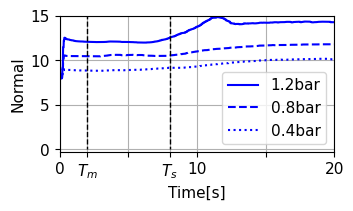

In [59]:
plt.figure(figsize=(3.54,3.54/2))

#Pressure
plotting_Force_PICKLE('Frictiontape_Different_pressure','Frictiontape_Different_pressure',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
save_name='14Sept_pressure_G'


#CA
#plotting_Force_PICKLE('Contact_area','Contact_area',False,1,'Normal Force[N]',['S','M','L'],'orange')
#save_name='14Sept_CA_G'



#HOR Off
#plotting_Force_PICKLE('OFF_Y','OFF_Y',False,1,'Normal Force[N]',['   0mm','-10mm','-20mm'],'green')
#save_name='14Sept_HOR_G'


#Ver Off
#plotting_Force_PICKLE('OFF_Z','OFF_Z',False,1,'Normal Force[N]',['80mm','60mm','40mm'],'brown')
#save_name='14Sept_VER_G'


plt.savefig(save_name+'.svg',bbox_inches='tight')

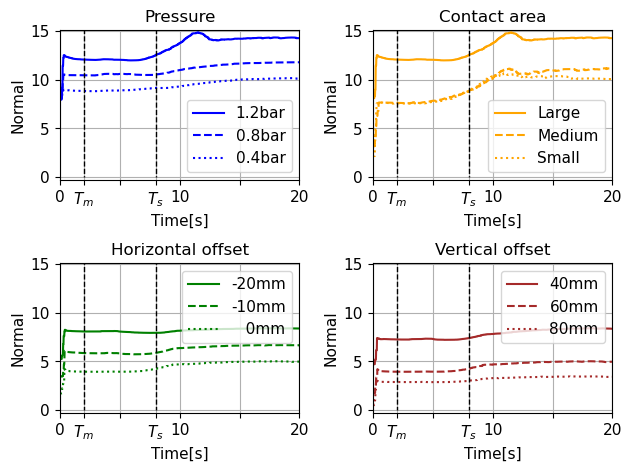

In [27]:
#plt.figure(figsize=(3.54,3.54))
plt.subplot(2,2,1)
plotting_Force_PICKLE('Frictiontape_Different_pressure','Frictiontape_Different_pressure',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
plt.title('Pressure')
plt.subplot(2,2,2)
plotting_Force_PICKLE('Contact_area','Contact_area',False,1,'Normal Force[N]',['Small','Medium','Large'],'orange')
plt.title('Contact area')
plt.subplot(2,2,3)
plotting_Force_PICKLE('OFF_Y','OFF_Y',False,1,'Normal Force[N]',['   0mm','-10mm','-20mm'],'green')
plt.title('Horizontal offset')
plt.subplot(2,2,4)
plt.title('Vertical offset')
plotting_Force_PICKLE('OFF_Z','OFF_Z',False,1,'Normal Force[N]',['80mm','60mm','40mm'],'brown')
plt.tight_layout(pad=1)

In [47]:
def ICRA_plotting_TRIPPLE_PICKLE(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color,Vline):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline)
def ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    

    
    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[1],color=Color,linestyle='solid') # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[0],color=Color,linestyle='dashed') # mean value FX/ mean Value Fy
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[2],color=Color,linestyle='dotted') # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    
    
    moving=Slip_point3[0]*pow(10,-9)
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.yticks(ticks=[0,0.25,0.5,0.75,1])
    plt.ylabel('Friction force / Normal force',fontsize="11")
   # plt.legend(fontsize="11")
    
    plt.ylim((-0.01, 1))
    plt.xlim((-0.01, 20.1))
    
    
    plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.subplot(2,1,1)
    '''
    lw=2
    if save_name=='Contact_area':
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',li
    elif save_name=='OFF_Z':
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
    else:
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
    moving=Slip_point3[0]*pow(10,-9)
    plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")
    #plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.xticks(ticks=[0,moving,10,20],labels=[0,'M',10,20],fontsize="11")
    plt.yticks(ticks=[0,5,10,15,20],fontsize="11")
    plt.ylim((-0.5, 20))
    plt.ylabel('Friction')
    plt.legend(fontsize="11",loc='upper left')
    '''

In [48]:
def ICRA_plotting_TRIPPLE_PICKLE_F(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color,Vline):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ICRA_plotting_TRIPPLE_Friction(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline)
def ICRA_plotting_TRIPPLE_Friction(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    
    '''
    plt.figure()
    plt.subplot(2,1,2)
    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[1],color=Color,linestyle='solid') # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[0],color=Color,linestyle='dashed') # mean value FX/ mean Value Fy
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[2],color=Color,linestyle='dotted') # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    
    
    moving=Slip_point3[0]*pow(10,-9)
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.yticks(ticks=[0,0.25,0.5,0.75,1])
    plt.ylabel('Friction force / Normal force',fontsize="11")
   # plt.legend(fontsize="11")
    
    plt.ylim((-0.01, 1))
    plt.xlim((-0.01, 20.1))
    
    
    plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.subplot(2,1,1)
    '''
    lw=2
    if save_name=='Contact_area':
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',li
    elif save_name=='OFF_Z':
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
    else:
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[0][2][:leng3], label=NAME_LABEL[2], color=Color,linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[0][2][:leng2], label=NAME_LABEL[1], color=Color,linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[0][2][:leng1], label=NAME_LABEL[0], color=Color,linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
    moving=Slip_point3[0]*pow(10,-9)
    plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.vlines(x = 8,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")
    plt.xticks(ticks=[0,moving,5,8,10,15,20],labels=[0,'$T_m$','','$T_s$',10,'',20],fontsize="11")
    plt.yticks(ticks=[0,5,10,15],fontsize="11")
    plt.ylim((-0.3, 16))
    plt.xlim((-0.1, 20))
    plt.ylabel('Friction[N]',fontsize="11")
    plt.legend(fontsize="11",loc='upper left')
    plt.grid()


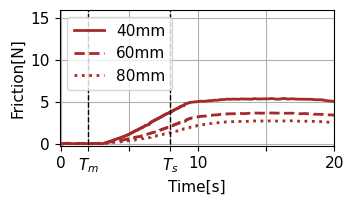

In [74]:
plt.figure(figsize=(3.54,3.54/2))
#Pressure

#save_name='14Sept_Fric_pressure_G'
#ICRA_plotting_TRIPPLE_PICKLE_F('Frictiontape_Different_pressure','f',False,['0.4bar','0.8bar','1.2bar'],'Friction coefficient','blue',1)


#Contact area
#save_name='14Sept_FRIC_CA_G'
#ICRA_plotting_TRIPPLE_PICKLE_F('Contact_area','Contact_area',False,['S','M','L'],'Friction coefficient','orange',1)



# Offset Hor
#save_name='14Sept_off_H_G'
#ICRA_plotting_TRIPPLE_PICKLE_F('OFF_Y','f',False,['  0mm','-10mm','-20mm'],'Friction coefficient','green',1)


# Offset Hor
save_name='14Sept_off_V_G'
ICRA_plotting_TRIPPLE_PICKLE_F('OFF_Z','OFF_Z',False,['80mm','60mm','40mm'],'Friction coefficient','brown',1)




plt.savefig(save_name+'.svg',bbox_inches='tight')

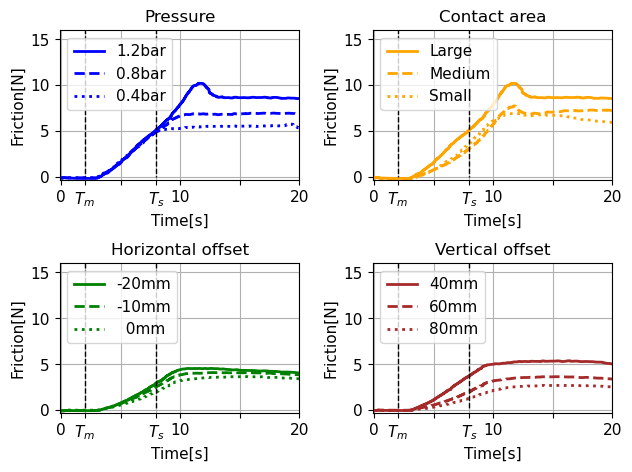

In [24]:
plt.figure()
plt.subplot(2,2,1)
ICRA_plotting_TRIPPLE_PICKLE_F('Frictiontape_Different_pressure','f',False,['0.4bar','0.8bar','1.2bar'],'Friction coefficient','blue',1)
plt.title('Pressure')
plt.subplot(2,2,2)
ICRA_plotting_TRIPPLE_PICKLE_F('Contact_area','Contact_area',False,['Small','Medium','Large'],'Friction coefficient','orange',1)
plt.title('Contact area')
plt.subplot(2,2,3)
ICRA_plotting_TRIPPLE_PICKLE_F('OFF_Y','f',False,['  0mm','-10mm','-20mm'],'Friction coefficient','green',1)
plt.title('Horizontal offset')
plt.subplot(2,2,4)
ICRA_plotting_TRIPPLE_PICKLE_F('OFF_Z','OFF_Z',False,['80mm','60mm','40mm'],'Friction coefficient','brown',1)
plt.title('Vertical offset')
plt.tight_layout(pad=1)

#save_name='night'
#plt.savefig(save_name+'.svg',bbox_inches='tight')

# 1. Normal and Friction force

In [13]:
def plotting_Force_PICKLE(pickle_path,save_name,save_fig,i,Title,NAME_LABEL):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ##
    
    ICRA_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title)
    
def ICRA_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    lw=1.5
    if i ==0 : # Friction force   
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[i][2][:leng3], label=NAME_LABEL[2], color='blue',linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[i][2][:leng2], label=NAME_LABEL[1], color='blue',linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[i][2][:leng1], label=NAME_LABEL[0], color='blue',linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
        
        
        
    else:
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[2], color='blue',linestyle='solid',lw=lw)
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[1], color='blue',linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[0], color='blue',linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
        
    moving=Slip_point3[0]*pow(10,-9)
    plt.vlines(x = moving,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.xlabel('Time[s]',fontsize="11")
    plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.yticks(ticks=[0,5,10,15,20],fontsize="11")
    plt.ylim((-0.5, 20))
    
    plt.ylabel(Title)
    plt.legend(fontsize="11",loc='upper left')
    
    
    plt.xlim((-0.1, 20.1))
def ICRA_plotting_TRIPPLE_PICKLE(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color,Vline):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline)
def ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)

    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[1],color=Color,linestyle='solid') # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[0],color=Color,linestyle='dashed') # mean value FX/ mean Value Fy
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL[2],color=Color,linestyle='dotted') # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    
    
    moving=Slip_point3[0]*pow(10,-9)
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,moving,5,10,15,20],labels=[0,'Move',5,10,15,20],fontsize="11")
    plt.yticks(ticks=[0,0.25,0.5,0.75,1])
    plt.ylabel('Friction force / Normal force',fontsize="11")
    plt.legend(fontsize="11")
    
    plt.ylim((-0.01, 1))
    plt.xlim((-0.01, 20.1))
    
    
    plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    
    

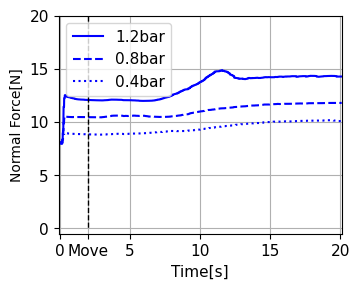

In [ ]:
plt.figure(figsize=(3.54,3.54/1.25),dpi =100)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'])
plt.tight_layout(pad=0.5)
plt.grid()
save_name='Normal_F'
plt.savefig(save_name+'.svg',bbox_inches='tight')
plt.savefig(save_name+'.pdf',bbox_inches='tight')

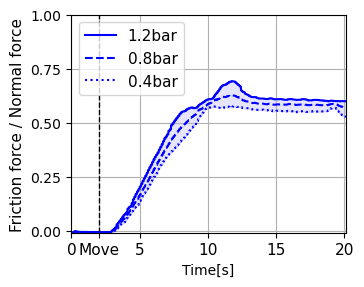

In [339]:
plt.figure(figsize=(3.54,3.54/1.25),dpi =100)
ICRA_plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,['0.8bar','1.2bar','0.4bar'],'Friction coefficient','blue',1)
plt.grid()

save_name='Ratio_F'
plt.savefig(save_name+'.svg',bbox_inches='tight')
plt.savefig(save_name+'.pdf',bbox_inches='tight')

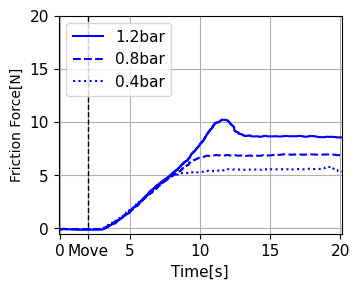

In [340]:
plt.figure(figsize=(3.54,3.54/1.25),dpi =100)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,0,'Friction Force[N]',['0.4bar','0.8bar','1.2bar'])
plt.grid()
plt.tight_layout(pad=0.5)
save_name='Friction_F'
plt.savefig(save_name+'.svg',bbox_inches='tight')
plt.savefig(save_name+'.pdf',bbox_inches='tight')

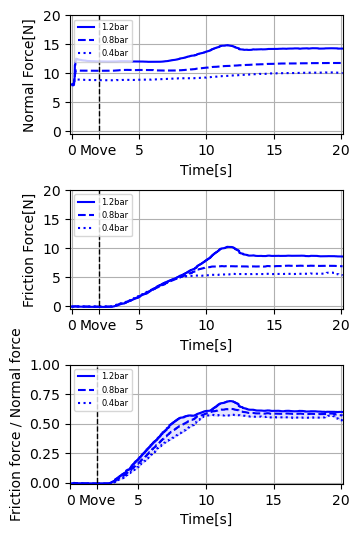

In [254]:
##Friction force
plt.figure(figsize=(3.54,3.54*1.5),dpi =100)
plt.subplot(3,1,1)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'])
plt.grid()
plt.subplot(3,1,2)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,0,'Friction Force[N]',['0.4bar','0.8bar','1.2bar'])
plt.grid()
plt.subplot(3,1,3)
ICRA_plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,['0.8bar','1.2bar','0.4bar'],'Friction coefficient','blue',1)
plt.grid()
plt.tight_layout(pad=0.5)
save_name='Modified_Normal_Fricition'

save_fig=True
if save_fig==True:
        plt.savefig(save_name+'.svg',bbox_inches='tight')
        plt.savefig(save_name+'.pdf',bbox_inches='tight')

# 2. Friction Coefficient

In [67]:
def ICRA_plotting_TRIPPLE_PICKLE(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color,Vline):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline)
def ICRA_plotting_TRIPPLE_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)

    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    
    plt.plot(Time1[:leng1]*pow(10,-9), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],color=Color,linestyle='dashed') # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='solid') # mean value FX/ mean Value Fy
    plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],color=Color,linestyle='dotted') # mean value FX/ mean Value Fy
    plt.fill_between(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1], np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],alpha=0.1, color=Color)
    
    
    
    plt.xlabel('Time[s]',fontsize="11")
    
    #plt.yticks(ticks=[0,0.25,0.5,0.6,0.75,1],labels=[0,0.25,0.5,0.6,0.75,1],fontsize="11")
    plt.yticks(ticks=[0,0.25,0.5,0.75,1],labels=[0,0.25,0.5,0.75,1],fontsize="11")
    plt.ylabel('Friction force / Normal force',fontsize="11")
    plt.legend(fontsize="11")
    
    plt.ylim((-0.01, 1))
    plt.xlim((-0.01, 20.1))
    
    
    if Vline==0:
        moving=Slip_point3[0]*pow(10,-9)
        plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
        plt.vlines(x = 8,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
        plt.hlines(y = 0.6,xmin = 0, xmax =20,color = 'red',linewidth = 2, linestyle ="--",label='mu=0.6')
        plt.xticks(ticks=[0,moving,5,8,10,15,20],labels=[0,'$T_m$','','$T_s$',10,'',20],fontsize="11")
        plt.grid()
        plt.legend(fontsize="11",loc='lower right')

    

<Figure size 354x177 with 0 Axes>

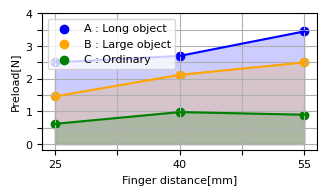

In [84]:
plt.figure(figsize=(3.54,3.54/2))
x=[25,40,55]
#pre1=[1.1,1.3,1.1]
#pre2=[1.9,1.8,1.6]
#pre3=[2.0,1.9,1.8]
pre1=[0.62,0.98,0.90]
pre2=[1.46,2.12,2.5]
pre3=[2.5,2.7,3.45]
plt.figure(figsize=(3.54,3.54/2))
pre=[pre1,pre2,pre3]
for i in range(3):
    if i ==0:
        k='A : Long object'
        col='blue'
    elif i==1:
        k='B : Large object'
        col='orange'
    else:
        k='C : Ordinary'
        col='green'
    
    plt.plot(x,pre[2-i],color=col)
    plt.scatter(x,pre[2-i],label=k,color=col)
    plt.fill_between(x,pre[2-i], [0,0,0],alpha=0.2,color=col)
plt.yticks(ticks=[0,0.5,1,1.5,2,2.5,3,3.5,4],labels=[0,'',1,'',2,'',3,'',4],fontsize="8")
plt.xticks(ticks=[25,32.5,40,47.5,55],labels=[25,'',40,'',55],fontsize="8")
plt.legend(fontsize="8")
plt.xlabel('Finger distance[mm]',fontsize="8")
plt.ylabel('Preload[N]',fontsize="8")
plt.grid()
save_name='val_2'
plt.savefig(save_name+'.svg',bbox_inches='tight')

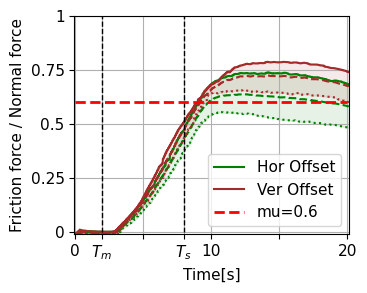

In [68]:
plt.figure(figsize=(3.54,3.54/1.25))
ICRA_plotting_TRIPPLE_PICKLE('OFF_Y',save_name,False,'Hor Offset','Friction coefficient','green',1)
ICRA_plotting_TRIPPLE_PICKLE('OFF_Z',save_name,False,'Ver Offset','Friction coefficient','brown',0)

save_name='14Sept_Fc_2'
save_fig=True
if save_fig==True:
        plt.savefig(save_name+'.svg',bbox_inches='tight')
        plt.savefig(save_name+'.pdf',bbox_inches='tight')

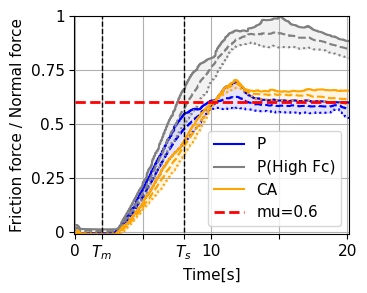

In [69]:
plt.figure(figsize=(3.54,3.54/1.25),dpi =100)
ICRA_plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,'P','Friction coefficient','blue',1)
ICRA_plotting_TRIPPLE_PICKLE('Friction_tape',save_name,False,'P(High Fc)','Friction coefficient','grey',1)
ICRA_plotting_TRIPPLE_PICKLE('Contact_area',save_name,False,'CA','Friction coefficient','orange',0)



save_name='14Sept_Fc_1_G'
save_fig=True
if save_fig==True:
        plt.savefig(save_name+'.svg',bbox_inches='tight')
        plt.savefig(save_name+'.pdf',bbox_inches='tight')

# 3. Deviation

In [76]:
def Deviation_Force_PICKLE(pickle_path,save_name,save_fig,i,Title,NAME_LABEL,Color):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']*pow(10,-9)
    Time2=loaded_data['Time2']*pow(10,-9)
    Time3=loaded_data['Time3']*pow(10,-9)
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    TIME=[Time1,Time2,Time3]
    TOTAL=[TOTAL1,TOTAL2,TOTAL3]
    
    return TIME,TOTAL

pressure | time for each variable  4.86,  4.86,  4.86
pressure | Magnitude difference  4.88,  4.92,  5.24
CA | time for each variable  4.86,  4.86,  4.86
CA | Magnitude difference  5.24,  3.35,  3.99
OFF_Y | time for each variable  4.86,  4.86,  4.86
OFF_Y | Magnitude difference  2.04,  2.65,  3.04
OFF_Z | time for each variable  4.85,  4.86,  4.86
OFF_Z | Magnitude difference  3.76,  1.34,  2.04


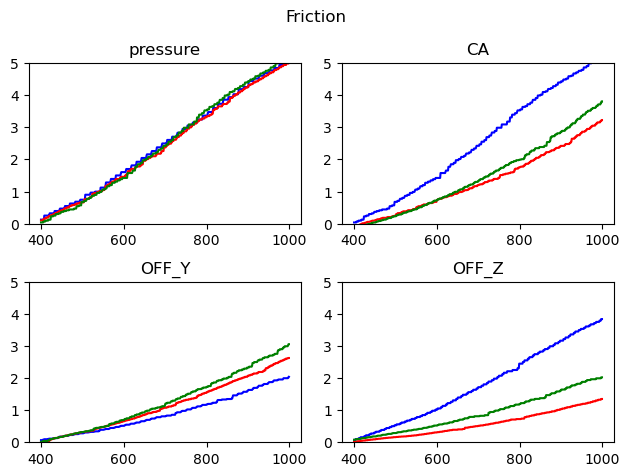

In [88]:
TIME,TOTAL=Deviation_Force_PICKLE('Frictiontape_Different_pressure','Frictiontape_Different_pressure',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
a=400
b=1000
Velocity=2 # mm/s
plt.figure()

plt.subplot(2,2,1)

plt.plot(list(range(len(TOTAL[0][0][2])))[400:1000],TOTAL[0][0][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][0][2])))[400:1000],TOTAL[1][0][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][0][2])))[400:1000],TOTAL[2][0][2][400:1000],color='green')
plt.ylim((0,5))
tit='pressure'
plt.title(tit)
print(f'{tit} | time for each variable  {TIME[1][b]-TIME[1][a]:0.2f},  {TIME[0][b]-TIME[0][a]:.2f},  {TIME[2][b]-TIME[2][a]:.2f}')
print(f'{tit} | Magnitude difference  {TOTAL[0][0][2][b]-TOTAL[0][0][2][a]:0.2f},  {TOTAL[1][0][2][b]-TOTAL[1][0][2][a]:.2f},  {TOTAL[2][0][2][b]-TOTAL[2][0][2][a]:.2f}')

TIME,TOTAL=Deviation_Force_PICKLE('Contact_area','Contact_area',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
plt.subplot(2,2,2)
tit='CA'
plt.title(tit)
plt.plot(list(range(len(TOTAL[0][0][2])))[400:1000],TOTAL[0][0][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][0][2])))[400:1000],TOTAL[1][0][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][0][2])))[400:1000],TOTAL[2][0][2][400:1000],color='green')
plt.ylim((0,5))
print(f'{tit} | time for each variable  {TIME[1][b]-TIME[1][a]:0.2f},  {TIME[0][b]-TIME[0][a]:.2f},  {TIME[2][b]-TIME[2][a]:.2f}')
print(f'{tit} | Magnitude difference  {TOTAL[0][0][2][b]-TOTAL[0][0][2][a]:0.2f},  {TOTAL[1][0][2][b]-TOTAL[1][0][2][a]:.2f},  {TOTAL[2][0][2][b]-TOTAL[2][0][2][a]:.2f}')

TIME,TOTAL=Deviation_Force_PICKLE('OFF_Y','OFF_Y',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]

plt.subplot(2,2,3)
tit='OFF_Y'
plt.title(tit)
plt.plot(list(range(len(TOTAL[0][0][2])))[400:1000],TOTAL[0][0][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][0][2])))[400:1000],TOTAL[1][0][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][0][2])))[400:1000],TOTAL[2][0][2][400:1000],color='green')
plt.ylim((0,5))
print(f'{tit} | time for each variable  {TIME[1][b]-TIME[1][a]:0.2f},  {TIME[0][b]-TIME[0][a]:.2f},  {TIME[2][b]-TIME[2][a]:.2f}')
print(f'{tit} | Magnitude difference  {TOTAL[0][0][2][b]-TOTAL[0][0][2][a]:0.2f},  {TOTAL[1][0][2][b]-TOTAL[1][0][2][a]:.2f},  {TOTAL[2][0][2][b]-TOTAL[2][0][2][a]:.2f}')

TIME,TOTAL=Deviation_Force_PICKLE('OFF_Z','OFF_Z',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
plt.subplot(2,2,4)
tit='OFF_Z'
plt.title(tit)
plt.plot(list(range(len(TOTAL[0][0][2])))[400:1000],TOTAL[0][0][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][0][2])))[400:1000],TOTAL[1][0][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][0][2])))[400:1000],TOTAL[2][0][2][400:1000],color='green')
plt.ylim((0,5))
print(f'{tit} | time for each variable  {TIME[1][b]-TIME[1][a]:0.2f},  {TIME[0][b]-TIME[0][a]:.2f},  {TIME[2][b]-TIME[2][a]:.2f}')
print(f'{tit} | Magnitude difference  {TOTAL[0][0][2][b]-TOTAL[0][0][2][a]:0.2f},  {TOTAL[1][0][2][b]-TOTAL[1][0][2][a]:.2f},  {TOTAL[2][0][2][b]-TOTAL[2][0][2][a]:.2f}')

plt.suptitle('Friction')
plt.tight_layout(pad=1)
# 'Frictiontape_Different_pressure'
# 'Contact_area'
# 'OFF_Y'
# 'OFF_Z'

pressure | first value= 8.28 | second value= 9.10 | Thrid value= 11.23
CA | first value= 11.23 | second value= 7.98 | Thrid value= 7.87
Offset Y | first value= 3.86 | second value= 5.15 | Thrid value= 6.61
Offset Z | first value= 6.58 | second value= 2.84 | Thrid value= 3.87


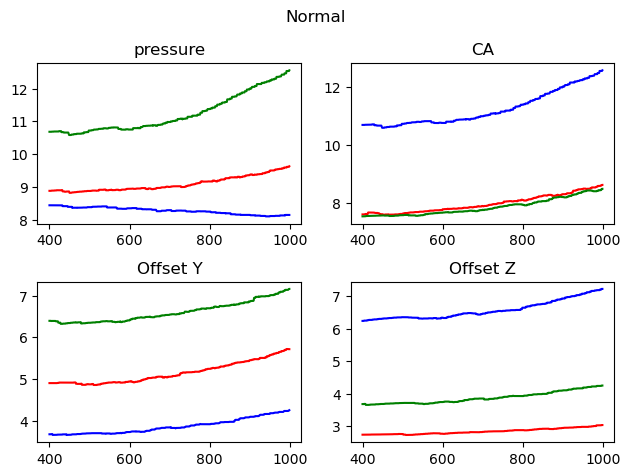

In [95]:
TIME,TOTAL=Deviation_Force_PICKLE('Frictiontape_Different_pressure','Frictiontape_Different_pressure',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 0.2bar 0.8bar 1.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
plt.figure()

plt.subplot(2,2,1)
plt.title('Pressure')
plt.plot(list(range(len(TOTAL[0][1][2])))[400:1000],TOTAL[0][1][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][1][2])))[400:1000],TOTAL[1][1][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][1][2])))[400:1000],TOTAL[2][1][2][400:1000],color='green')

tit='pressure'
plt.title(tit)
a1=np.mean(TOTAL[0][1][2][400:1000])
a2=np.mean(TOTAL[1][1][2][400:1000])
a3=np.mean(TOTAL[2][1][2][400:1000])
#print(f'{tit} | time for each variable  {TIME[1][b]-TIME[1][a]:0.2f},  {TIME[0][b]-TIME[0][a]:.2f},  {TIME[2][b]-TIME[2][a]:.2f}')
#print(f'{tit} | Magnitude difference  {TOTAL[0][0][2][b]-TOTAL[0][0][2][a]:0.2f},  {TOTAL[1][0][2][b]-TOTAL[1][0][2][a]:.2f},  {TOTAL[2][0][2][b]-TOTAL[2][0][2][a]:.2f}')
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')


#################################
TIME,TOTAL=Deviation_Force_PICKLE('Contact_area','Contact_area',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
plt.subplot(2,2,2)
tit='CA'
plt.title(tit)
a1=np.mean(TOTAL[0][1][2][400:1000])
a2=np.mean(TOTAL[1][1][2][400:1000])
a3=np.mean(TOTAL[2][1][2][400:1000])
plt.plot(list(range(len(TOTAL[0][1][2])))[400:1000],TOTAL[0][1][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][1][2])))[400:1000],TOTAL[1][1][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][1][2])))[400:1000],TOTAL[2][1][2][400:1000],color='green')
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')


#################################
TIME,TOTAL=Deviation_Force_PICKLE('OFF_Y','OFF_Y',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]

plt.subplot(2,2,3)
tit='Offset Y'
plt.title(tit)
a1=np.mean(TOTAL[0][1][2][400:1000])
a2=np.mean(TOTAL[1][1][2][400:1000])
a3=np.mean(TOTAL[2][1][2][400:1000])
plt.plot(list(range(len(TOTAL[0][1][2])))[400:1000],TOTAL[0][1][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][1][2])))[400:1000],TOTAL[1][1][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][1][2])))[400:1000],TOTAL[2][1][2][400:1000],color='green')
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')

#################################
TIME,TOTAL=Deviation_Force_PICKLE('OFF_Z','OFF_Z',False,1,'Normal Force[N]',['0.4bar','0.8bar','1.2bar'],'blue')
# Total[parameter variable 1.2bar 0.8bar 0.2bar][Force direction 0->Friction 1->Normal, 2->vertical][deviation 0: max, 1:min, 2: Mean]
plt.subplot(2,2,4)
tit='Offset Z'
plt.title(tit)
a1=np.mean(TOTAL[0][1][2][400:1000])
a2=np.mean(TOTAL[1][1][2][400:1000])
a3=np.mean(TOTAL[2][1][2][400:1000])
plt.plot(list(range(len(TOTAL[0][1][2])))[400:1000],TOTAL[0][1][2][400:1000],color='blue')
plt.plot(list(range(len(TOTAL[1][1][2])))[400:1000],TOTAL[1][1][2][400:1000],color='red')
plt.plot(list(range(len(TOTAL[2][1][2])))[400:1000],TOTAL[2][1][2][400:1000],color='green')
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')
plt.suptitle('Normal')
plt.tight_layout(pad=1)


In [111]:
def DEV_Friction_PICKLE(pickle_path,save_name,save_fig,NAME_LABEL,Title,Color,Vline):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    #DEV_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline)
    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    
    return TEMP_Fc1,TEMP_Fc2,TEMP_Fc3
def DEV_Friction_Coeff(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,Title,Color,Vline):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)

    TEMP_Fc1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
    TEMP_Fc2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
    TEMP_Fc3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))
    TOTAL_TEMP=TEMP_Fc1[:leng1],TEMP_Fc2[:leng1],TEMP_Fc3[:leng1]
    
    plt.plot((list(range(len(np.mean(np.array(TOTAL_TEMP)))))), np.mean(np.array(TOTAL_TEMP), axis=0)[:leng1],color=Color,linestyle='dashed') # mean value FX/ mean Value Fy
    #plt.plot(Time1[:leng1]*pow(10,-9), np.max(np.array(TOTAL_TEMP), axis=0)[:leng1],label=NAME_LABEL,color=Color,linestyle='solid') # mean value FX/ mean Value Fy
    #plt.plot(Time1[:leng1]*pow(10,-9), np.min(np.array(TOTAL_TEMP), axis=0)[:leng1],color=Color,linestyle='dotted') # mean value FX/ mean Value Fy
    
    
    
    
    plt.xlabel('Time[s]',fontsize="11")
    
    #plt.yticks(ticks=[0,0.25,0.5,0.6,0.75,1],labels=[0,0.25,0.5,0.6,0.75,1],fontsize="11")
    plt.yticks(ticks=[0,0.25,0.5,0.75,1],labels=[0,0.25,0.5,0.75,1],fontsize="11")
    plt.ylabel('Friction force / Normal force',fontsize="11")
    plt.legend(fontsize="11")
    
    plt.ylim((-0.01, 1))
    plt.xlim((-0.01, 20.1))
    
    
    if Vline==0:
        moving=Slip_point3[0]*pow(10,-9)
        plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
        plt.vlines(x = 8,ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
        plt.hlines(y = 0.6,xmin = 0, xmax =20,color = 'red',linewidth = 2, linestyle ="--",label='mu=0.6')
        plt.xticks(ticks=[0,moving,5,8,10,15,20],labels=[0,'$T_m$','','$T_s$',10,'',20],fontsize="11")
    
        plt.legend(fontsize="11",loc='lower right')

Pressure | first value= 0.55 | second value= 0.59 | Thrid value= 0.61
CA | first value= 0.61 | second value= 0.65 | Thrid value= 0.64
OFF_Y | first value= 0.73 | second value= 0.61 | Thrid value= 0.52
OFF_Z | first value= 0.64 | second value= 0.78 | Thrid value= 0.73


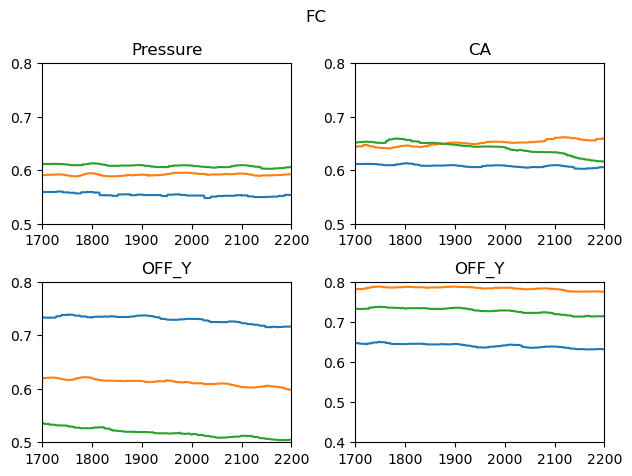

In [138]:
plt.subplot(2,2,1)
a,b,c=DEV_Friction_PICKLE('Frictiontape_Different_pressure',save_name,False,'Hor Offset','Friction coefficient','green',1)
plt.plot(list(range(len(a))),list(a))
plt.plot(list(range(len(b))),list(b))
plt.plot(list(range(len(c))),list(c))
plt.xlim(1700,2200)
plt.ylim(0.5,0.8)


a1=np.mean(a[1700:2200])
a2=np.mean(b[1700:2200])
a3=np.mean(c[1700:2200])
tit='Pressure'
plt.title(tit)
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')
#############
plt.subplot(2,2,2)
a,b,c=DEV_Friction_PICKLE('Contact_area',save_name,False,'Hor Offset','Friction coefficient','green',1)
plt.plot(list(range(len(a))),list(a))
plt.plot(list(range(len(b))),list(b))
plt.plot(list(range(len(c))),list(c))
plt.xlim(1700,2200)
plt.ylim(0.5,0.8)


a1=np.mean(a[1700:2200])
a2=np.mean(b[1700:2200])
a3=np.mean(c[1700:2200])
tit='CA'
plt.title(tit)
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')


###########
plt.subplot(2,2,3)
a,b,c=DEV_Friction_PICKLE('OFF_Y',save_name,False,'Hor Offset','Friction coefficient','green',1)
plt.plot(list(range(len(a))),list(a))
plt.plot(list(range(len(b))),list(b))
plt.plot(list(range(len(c))),list(c))
plt.xlim(1700,2200)
plt.ylim(0.5,0.8)


a1=np.mean(a[1700:2200])
a2=np.mean(b[1700:2200])
a3=np.mean(c[1700:2200])
tit='OFF_Y'
plt.title(tit)
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')
##########
plt.subplot(2,2,4)
a,b,c=DEV_Friction_PICKLE('OFF_Z',save_name,False,'Hor Offset','Friction coefficient','green',1)
plt.plot(list(range(len(a))),list(a))
plt.plot(list(range(len(b))),list(b))
plt.plot(list(range(len(c))),list(c))
plt.xlim(1700,2200)
plt.ylim(0.4,0.8)


a1=np.mean(a[1700:2200])
a2=np.mean(b[1700:2200])
a3=np.mean(c[1700:2200])
plt.title(tit)
tit='OFF_Z'
print(f'{tit} | first value= {a1:.2f} | second value= {a2:.2f} | Thrid value= {a3:.2f}')



#DEV_Friction_PICKLE('OFF_Z',save_name,False,'Ver Offset','Friction coefficient','brown',0)
#plt.grid()
#save_name='Sept_Fc_2'
#save_fig=False
#if save_fig==True:
##        plt.savefig(save_name+'.svg',bbox_inches='tight')
  #      plt.savefig(save_name+'.pdf',bbox_inches='tight')

plt.suptitle('FC')
plt.tight_layout(pad=1)

# 3. Manufacturer

1


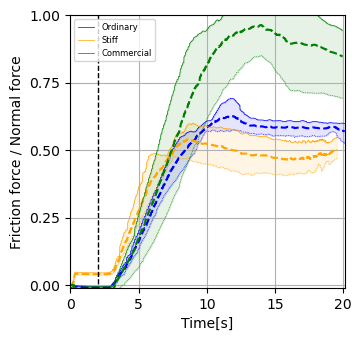

In [150]:
plt.figure(figsize=(3.54,3.54),dpi =100)
ICRA_plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,'Ordinary','Friction coefficient','blue',1)
ICRA_plotting_TRIPPLE_PICKLE('Stiff_Finger_DifferentP',save_name,False,'Stiff','Friction coefficient','orange',1)
ICRA_plotting_TRIPPLE_PICKLE('Commercial_Finger_DifferentP',save_name,False,'Commercial','Friction coefficient','green',0)

plt.grid()
save_name='Manufacturer'
save_fig=True
if save_fig==True:
        plt.savefig(save_name+'.svg',bbox_inches='tight')
        plt.savefig(save_name+'.pdf',bbox_inches='tight')

# 4. One finger + Two finger

In [198]:
def TWO_plotting_Force_PICKLE(pickle_path,save_name,save_fig,Title,NAME_LABEL,i):
    with open(pickle_path, 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)
    Time1=loaded_data['Time1']
    Time2=loaded_data['Time2']
    Time3=loaded_data['Time3']
    TOTAL1=loaded_data['TOTAL1']
    TOTAL2=loaded_data['TOTAL2']
    TOTAL3=loaded_data['TOTAL3']
    DATA_NAME1=loaded_data['DATA_NAME1']
    DATA_NAME2=loaded_data['DATA_NAME2']
    DATA_NAME3=loaded_data['DATA_NAME3']
    Slip_point1=loaded_data['Slip_point1']
    Slip_point2=loaded_data['Slip_point2']
    Slip_point3=loaded_data['Slip_point3']
    #NAME_LABEL=loaded_data['NAME_LABEL']
    ##
    
    TWO_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title)
def TWO_plotting_force(save_name,save_fig,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL,i,Title):
    '''
    Arag
    '''
    leng1=round(len(Time1)/2)
    leng2=round(len(Time2)/2)
    leng3=round(len(Time3)/2)
    lw=1.5
    if i ==0 : # Friction force   
        
        plt.plot(Time2[:leng2]*pow(10,-9), TOTAL2[i][2][:leng2], label=NAME_LABEL[1], color='blue',linestyle='solid',lw=lw)
        
        plt.plot(Time1[:leng1]*pow(10,-9), TOTAL1[i][2][:leng1], label=NAME_LABEL[0], color='blue',linestyle='dashed',lw=lw)
        plt.plot(Time3[:leng3]*pow(10,-9), TOTAL3[i][2][:leng3], label=NAME_LABEL[2], color='blue',linestyle='dotted',lw=lw)
        
        #plt.fill_between(Time1[:leng1]*pow(10,-9), TOTAL1[i][1][:leng1], TOTAL1[i][0][:leng1], alpha=0.4, color='blue',linestyle='solid',lw=lw)
        
        #plt.fill_between(Time2[:leng2]*pow(10,-9), TOTAL2[i][1][:leng2], TOTAL2[i][0][:leng2], alpha=0.4, color='blue',linestyle='dashed',lw=lw)
        
        #plt.fill_between(Time3[:leng3]*pow(10,-9), TOTAL3[i][1][:leng3], TOTAL3[i][0][:leng3], alpha=0.4, color='blue',linestyle='dotted',lw=lw)
        
        
    else:
        #plt.fill_between(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][1])*(TOTAL1[1][1])+(TOTAL1[2][1])*(TOTAL1[2][1]))[:leng1], np.sqrt((TOTAL1[1][0])*(TOTAL1[1][0])+(TOTAL1[2][0])*(TOTAL1[2][0]))[:leng1], alpha=0.4, color='blue')
        plt.plot(Time1[:leng1]*pow(10,-9), np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))[:leng1], label=NAME_LABEL[0], color='orange',linestyle='dotted',lw=lw)
        #plt.fill_between(Time2[:leng2]*pow(10,-9),  np.sqrt((TOTAL2[1][1])*(TOTAL2[1][1])+(TOTAL2[2][1])*(TOTAL2[2][1]))[:leng2], np.sqrt((TOTAL2[1][0])*(TOTAL2[1][0])+(TOTAL2[2][0])*(TOTAL2[2][0]))[:leng2], alpha=0.4, color='red')
        plt.plot(Time2[:leng2]*pow(10,-9), np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))[:leng2], label=NAME_LABEL[1], color='orange',linestyle='dashed',lw=lw)
        #plt.fill_between(Time3[:leng3]*pow(10,-9),  np.sqrt((TOTAL3[1][1])*(TOTAL3[1][1])+(TOTAL3[2][1])*(TOTAL3[2][1]))[:leng3], np.sqrt((TOTAL3[1][0])*(TOTAL3[1][0])+(TOTAL3[2][0])*(TOTAL3[2][0]))[:leng3], alpha=0.4, color='black')
        plt.plot(Time3[:leng3]*pow(10,-9), np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))[:leng3], label=NAME_LABEL[2], color='orange',linestyle='solid',lw=lw)
    plt.vlines(x = Slip_point3[0]*pow(10,-9),ymin = 20, ymax =0,color = 'black',linewidth = 1, linestyle ="--")
    plt.ylabel('Friction force  [N]')
    plt.xlabel('Time[s]')
    plt.xticks(ticks=[0,5,10,15,20])
    #plt.yticks(ticks=[0,5,10,15,20])
    plt.ylim((-0.01, 5))
    plt.legend(fontsize="6",loc='upper left')
    
    
    plt.xlim((-0.1, 20.1))    

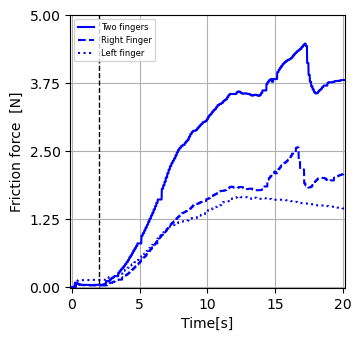

In [201]:
plt.figure(figsize=(3.54,3.54),dpi =100)
TWO_plotting_Force_PICKLE('TWO_finger_Right_Left',False,False,'Friction Force',['Right Finger','Two fingers','Left finger'],0)
plt.yticks(ticks=[0,1.25,2.5,3.75,5])
plt.grid()
save_name='Number_of_Finger'
save_fig=True
if save_fig==True:
        plt.savefig(save_name+'.svg',bbox_inches='tight')
        plt.savefig(save_name+'.pdf',bbox_inches='tight')

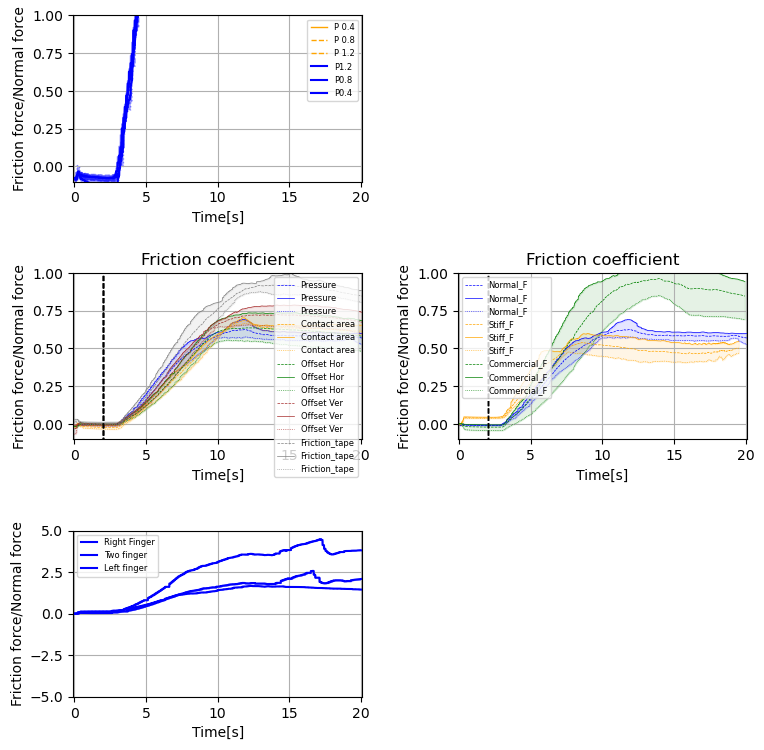

In [32]:
save_name='1'
plt.figure(figsize=(8,10))
plt.subplot(4,2,1)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,1,'Normal Force',17,['P1.2','P0.8','P0.4'])
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,0,'Friction Force',17,['P1.2','P0.8','P0.4'])
plt.grid()
plt.subplot(4,2,3)
plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,'Pressure','Friction coefficient','blue')
plotting_TRIPPLE_PICKLE('Contact_area',save_name,False,'Contact area','Friction coefficient','orange')
plotting_TRIPPLE_PICKLE('OFF_Y',save_name,False,'Offset Hor','Friction coefficient','green')
plotting_TRIPPLE_PICKLE('OFF_Z',save_name,False,'Offset Ver','Friction coefficient','brown')
plotting_TRIPPLE_PICKLE('Friction_tape',save_name,False,'Friction_tape','Friction coefficient','grey')
plt.subplot(4,2,4)
plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',save_name,False,'Normal_F','Friction coefficient','blue')
plotting_TRIPPLE_PICKLE('Stiff_Finger_DifferentP',save_name,False,'Stiff_F','Friction coefficient','orange')
plotting_TRIPPLE_PICKLE('Commercial_Finger_DifferentP',save_name,False,'Commercial_F','Friction coefficient','green')
plt.subplot(4,2,5)
plotting_Force_PICKLE('TWO_finger_Right_Left',False,False,0,'Friction Force',7,['Right Finger','Two finger','Left finger'])
plt.yticks(ticks=[-5,-2.5,0,2.5,5])
plt.tight_layout(pad=2)
save_fig=False
save_name='Different_Design'
if save_fig==True:
        plt.savefig(save_name+'.png')


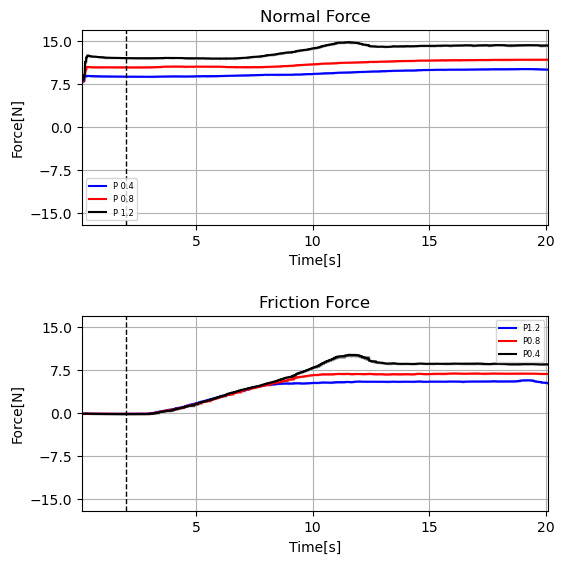

In [21]:
plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,1,'Normal Force',17,['P1.2','P0.8','P0.4'])
plt.subplot(2,1,2)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,0,'Friction Force',17,['P1.2','P0.8','P0.4'])
plt.tight_layout(pad=2)

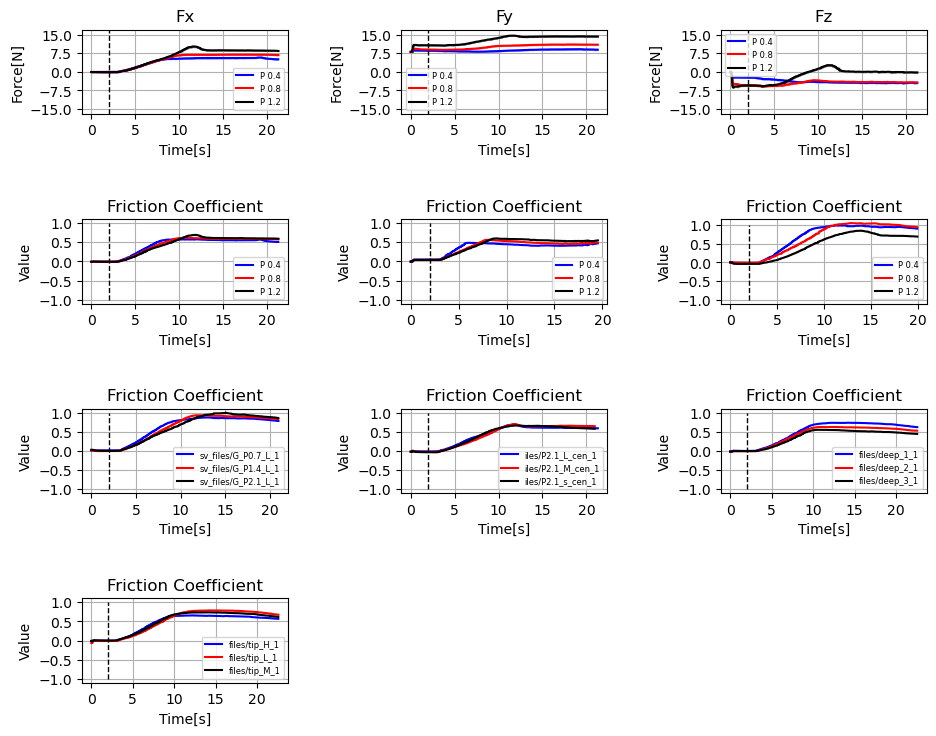

In [180]:
plt.figure(figsize=(10,8))
plt.subplot(4,3,1)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,0)
plt.subplot(4,3,2)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,1)
plt.subplot(4,3,3)
plotting_Force_PICKLE('Frictiontape_Different_pressure',False,False,2)
plt.subplot(4,3,4)
plotting_TRIPPLE_PICKLE('Frictiontape_Different_pressure',False,False)
plt.subplot(4,3,5)
plotting_TRIPPLE_PICKLE('Stiff_Finger_DifferentP',False,False)
plt.subplot(4,3,6)
plotting_TRIPPLE_PICKLE('Commercial_Finger_DifferentP',False,False)
plt.subplot(4,3,7)
plotting_TRIPPLE_PICKLE('Friction_tape',False,False)
plt.subplot(4,3,8)
plotting_TRIPPLE_PICKLE('Contact_area',False,False)
plt.subplot(4,3,9)
plotting_TRIPPLE_PICKLE('OFF_Y',False,False)
plt.subplot(4,3,10)
plotting_TRIPPLE_PICKLE('OFF_Z',False,False)
plt.tight_layout(pad=3)

save_fig=False
save_name='Different_Design'
if save_fig==True:
        plt.savefig(save_name+'.png')


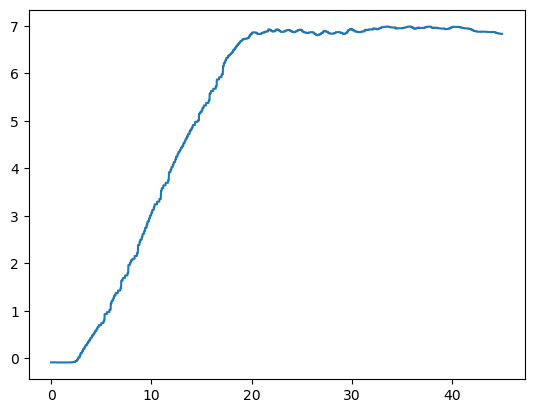

In [147]:
X1,Y1,Y2=strain_stiffness_value_generator(TOTAL1[0][2],data_idx1,50,45)

plt.plot(X1,Y1)


In [177]:
path='./OFF_Z_csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로  
##################################
Desired_param=[[0],[0],[0,1,2]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
new_list=A.Desired_file_directory
print(new_list)

1st Folder name :  tip_H_1
Contents in the folder : ['ANALOGUE.csv', 'Force.csv', 'TCP.csv'] 


1 Parameters ['tip'] 

2 Parameters ['H' 'L' 'M'] 

3 Parameters ['1' '2'] 



IndexError: index 2 is out of bounds for axis 0 with size 2

In [178]:
path='./OFF_Z_csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로   
##################################
##################################
Desired_param=[[0],[0],[0,1]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME1=new_list[0][12:]

full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
INFL_INDEX, SLIP_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)

Time1,TOTAL1, NAME_LABEL,Slip_point1=Force_data_average(full_path_FORCE,INFL_INDEX,SLIP_INDEX)


####################################
Desired_param=[[0],[1],[0,1]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME2=new_list[0][12:]
DATA_NAME2
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
INFL_INDEX, SLIP_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)

Time2,TOTAL2, NAME_LABEL2,Slip_point2=Force_data_average(full_path_FORCE,INFL_INDEX,SLIP_INDEX)

####################################
Desired_param=[[0],[2],[0,1]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME3=new_list[0][12:]
DATA_NAME3
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
INFL_INDEX, SLIP_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)

Time3,TOTAL3, NAME_LABEL3,Slip_point3=Force_data_average(full_path_FORCE,INFL_INDEX,SLIP_INDEX)

1st Folder name :  tip_H_1
Contents in the folder : ['ANALOGUE.csv', 'Force.csv', 'TCP.csv'] 


1 Parameters ['tip'] 

2 Parameters ['H' 'L' 'M'] 

3 Parameters ['1' '2'] 

['./OFF_Z_csv_files/tip_H_1', './OFF_Z_csv_files/tip_H_2']
1st Folder name :  tip_H_1
Contents in the folder : ['ANALOGUE.csv', 'Force.csv', 'TCP.csv'] 


1 Parameters ['tip'] 

2 Parameters ['H' 'L' 'M'] 

3 Parameters ['1' '2'] 

['./OFF_Z_csv_files/tip_L_1', './OFF_Z_csv_files/tip_L_2']
1st Folder name :  tip_H_1
Contents in the folder : ['ANALOGUE.csv', 'Force.csv', 'TCP.csv'] 


1 Parameters ['tip'] 

2 Parameters ['H' 'L' 'M'] 

3 Parameters ['1' '2'] 

['./OFF_Z_csv_files/tip_M_1', './OFF_Z_csv_files/tip_M_2']


In [14]:
TOTAL1[0][2]

array([-0.07725565, -0.07725565, -0.07725565, ..., -6.45556362,
       -6.45556362, -6.45556362])

In [16]:
AAAA

array([-0.70710678, -0.70710678, -0.70710678, ..., -0.70710678,
       -0.70710678, -0.70710678])

In [22]:
C1=TOTAL1[0][2]/np.sqrt((TOTAL1[1][2])*(TOTAL1[1][2])+(TOTAL1[2][2])*(TOTAL1[2][2]))
C2=TOTAL2[0][2]/np.sqrt((TOTAL2[1][2])*(TOTAL2[1][2])+(TOTAL2[2][2])*(TOTAL2[2][2]))
C3=TOTAL3[0][2]/np.sqrt((TOTAL3[1][2])*(TOTAL3[1][2])+(TOTAL3[2][2])*(TOTAL3[2][2]))

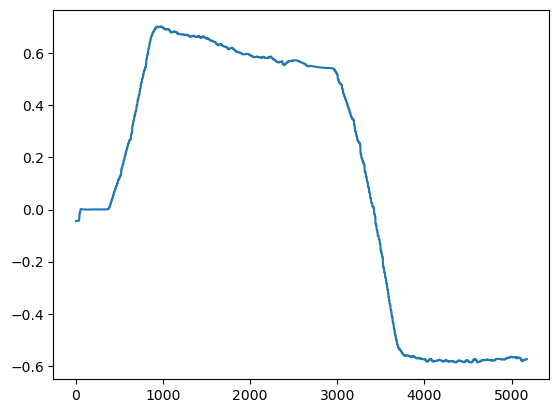

In [24]:
plt.plot(C1)

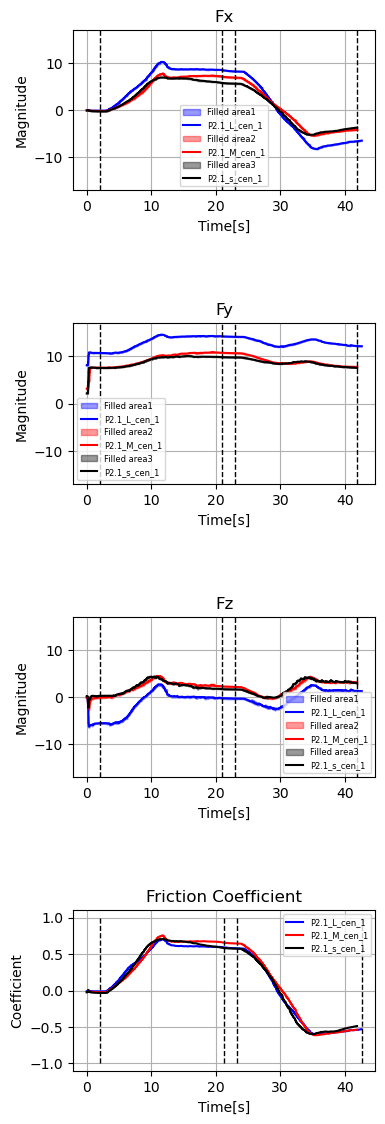

In [186]:
plotting_TRIPPLE('2.1Pressure with different contact area',True,Time1,TOTAL1, DATA_NAME1,Slip_point1,Time2,TOTAL2, DATA_NAME2,Slip_point2,Time3,TOTAL3, DATA_NAME3,Slip_point3,NAME_LABEL3)

1st Folder name :  P0.7_L_cen_1
Contents in the folder : ['ANALOGUE.csv', 'Force.csv', 'TCP.csv'] 


1 Parameters ['P0.7' 'P1.4' 'P2.1'] 

2 Parameters ['L' 'M' 's'] 

3 Parameters ['cen'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P0.7_L_cen_1', './csv_files/P0.7_L_cen_3']


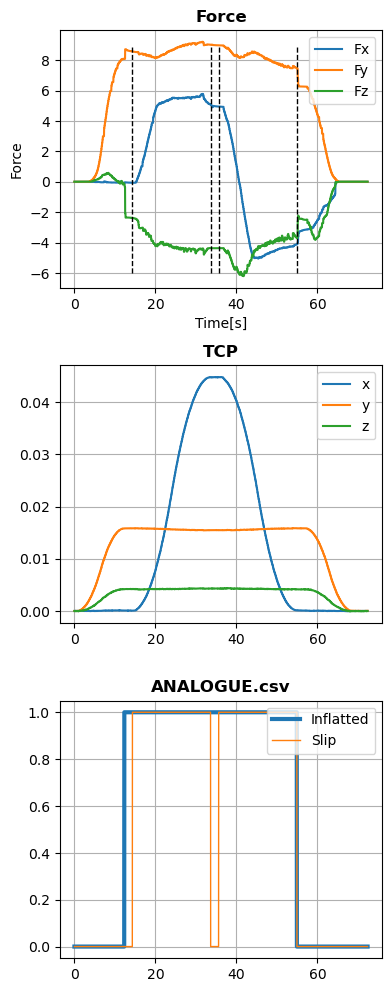

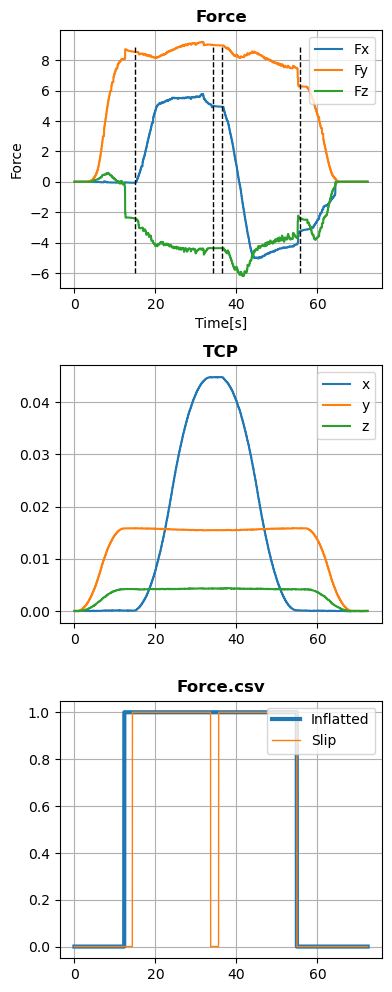

In [113]:
path='./csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로 
path='./csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로 
Desired_param=[[0],[0],[0],[0,2]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
new_list=A.Desired_file_directory

print(new_list)
DATA_NAME1=new_list[0][12:]
DATA_NAME1
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
#INFL_INDEX, SLIP_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)

plot_everything(new_list,SLIP_INDEX)

In [54]:
Find_range_ch1(full_path_ANAL,0)

[[1537, 6862], [1627, 6952]]

In [55]:
Find_range_ch1(full_path_ANAL,1)

[[1787, 4201, 4449, 6864], [1877, 4291, 4539, 6954]]

In [62]:
def Find_Time_Range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]]])
    return time_range
def Find_Time_Range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][2]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][3]]])
    return time_range

In [63]:
print(Find_Time_Range_ch2(full_path_ANAL,1))



#Find_range_ch2(full_path_ANAL,1)
#Find_range_ch2

[[14295238414, 33606588954, 35590504327, 54909735831], [15015294878, 34326575183, 36310557710, 55629745852]]


In [73]:
AA=Find_Force_Index(full_path_FORCE,full_path_ANAL)

In [74]:
AA

([[1519, 6780], [1607, 6868]],
 [[1766, 4151, 4396, 6782], [1854, 4239, 4485, 6871]])

In [72]:
## Data aligning
## Analogue signal related
def find_change_points(file_path): # find the change point
    '''
    Arg: analogue file path (only one file)=> To find specific change point
    Output : Two values(start => end)
    '''
    df = pd.read_csv(file_path,header=None)
    index_of_changes1 = []
    previous_value1 = None
    index_of_changes2 = []
    previous_value2 = None

    for index, row in df.iterrows():
        current_value1 = row[1]
        current_value2 = row[2]

        if current_value1 != previous_value1:
            index_of_changes1.append(index)
        if current_value2 != previous_value2:
            index_of_changes2.append(index)
    
        previous_value1 = current_value1
        previous_value2 = current_value2
    if len(index_of_changes1)==3:
        results1=index_of_changes1[1:3]
    else:
        results1=index_of_changes1[1:3]
        print(f'Error in Analogue signal file 1st column finding change point in boolean list but it has {results1} ')
        results1="THE VALUE IS WRONG"
    
    if len(index_of_changes2)==5:
        results2=index_of_changes2[1:5]
    else:
        results2=index_of_changes2[1:]
        print(f'Error in Analogue signal file 2nd column finding change point in boolean list but it has {results2}')
        results2="THE VALUE IS WRONG"
    return results1,results2


def Find_range_ch1(path_direcotry_whole_file_list,channel_num):
    '''
    ARG : Wanted file list + 
    OUTPUT : Find range for each file <High and low >
    '''
    range_index=[]
    diff_index=[]
    for i in range(len(path_direcotry_whole_file_list)):
        file_path_for_range=path_direcotry_whole_file_list[i]
        range_index.append(find_change_points(file_path_for_range)[channel_num])
        diff_index.append(find_change_points(file_path_for_range)[channel_num][1]-find_change_points(file_path_for_range)[channel_num][0])
    if check_all_same(diff_index):
        result=range_index
    else:
        print(f'Difference in indexing for each file{diff_index}')
        result='Find range Fail'
    return result



def Find_range_ch2(path_direcotry_whole_file_list,channel_num):
    '''
    ARG : Wanted file list + 
    OUTPUT : Find range for each file[High and low  && High and low]
    '''
    range_index=[]
    diff_index1=[]
    diff_index2=[]
    for i in range(len(path_direcotry_whole_file_list)):
        file_path_for_range=path_direcotry_whole_file_list[i]
        range_index.append(find_change_points(file_path_for_range)[channel_num])
        diff_index1.append(find_change_points(file_path_for_range)[channel_num][1]-find_change_points(file_path_for_range)[channel_num][0])
        diff_index2.append(find_change_points(file_path_for_range)[channel_num][3]-find_change_points(file_path_for_range)[channel_num][2])
    
    if check_all_same(diff_index1) and check_all_same(diff_index2):
        result= range_index
    else :
        print(f'Error in searching range at Analaogue file for 1st direction Movement {diff_index1}')
        print(f'Error in searching range at Analaogue file for 1st direction Movement {diff_index2}')
        result='Error occurred'
    return result


def Find_Time_Range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch=0):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]]])
    return time_range
def Find_Time_Range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch=1):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch)[i][0]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][1]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][2]],df[0][Find_range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch)[i][3]]])
    return time_range



def Find_Force_Index(path_direcotry_whole_file_list_FORCE,path_direcotry_whole_file_list_ANALOGUE,ch1=0,ch2=1):
    T_val_list1=Find_Time_Range_ch1(path_direcotry_whole_file_list_ANALOGUE,ch1)
    T_val_list2=Find_Time_Range_ch2(path_direcotry_whole_file_list_ANALOGUE,ch2)
    F_ch1_index_list=[]
    F_ch2_index_list=[]
    for i in range(len(path_direcotry_whole_file_list_FORCE)):
        df_force_np=pd.read_csv(path_direcotry_whole_file_list_FORCE[i],header=None)[0].to_numpy()
        # Channel1
        if i ==0:
            ch1_1=np.argmin(abs(df_force_np-T_val_list1[i][0]))
            ch1_2=np.argmin(abs(df_force_np-T_val_list1[i][1]))
            stride=ch1_2-ch1_1
            F_ch1_index_list.append([ch1_1,ch1_1+stride])
        else:
            ch1_1=np.argmin(abs(df_force_np-T_val_list1[i][0]))
            F_ch1_index_list.append([ch1_1,ch1_1+stride])
        
        # Channel2
        if i ==0:
            ch2_1=np.argmin(abs(df_force_np-T_val_list2[i][0]))
            ch2_2=np.argmin(abs(df_force_np-T_val_list2[i][1]))
            stride_ch2_1=ch2_2-ch2_1
            ch2_3=np.argmin(abs(df_force_np-T_val_list2[i][2]))
            ch2_4=np.argmin(abs(df_force_np-T_val_list2[i][3]))
            stride_ch2_2=ch2_4-ch2_3
            F_ch2_index_list.append([ch2_1,ch2_1+stride_ch2_1,ch2_3,ch2_3+stride_ch2_2])
        else:
            ch2_1=np.argmin(abs(df_force_np-T_val_list2[i][0]))
            ch2_3=np.argmin(abs(df_force_np-T_val_list2[i][2]))
            F_ch2_index_list.append([ch2_1,ch2_1+stride_ch2_1,ch2_3,ch2_3+stride_ch2_2])
            

    result_ch1=F_ch1_index_list
    result_ch2=F_ch2_index_list
    return result_ch1, result_ch2






def check_all_same(lst):# check up all the same value in the list(find the check point
    return all(element == lst[0] for element in lst)



In [10]:
def tcp_moving_range(full_path_TCP):
    '''
    Goal : Find the value when it starts to moving and stopping ==> X direction
    Arg : path
    Result : Time value of starting and end point[second]
    
    '''
    Result=[]
    for i in range(len(full_path_TCP)):
        df = pd.read_csv(full_path_TCP[i],names=['Time','X','Y','Z'])
        TCP_X = df['X']-df['X'][0]
        TCP_time=df['Time']-df['Time'][0]
        start_FINDER=True
        end_FINDER=True
        for index, row in enumerate(TCP_X):
            if row<-0.004 and start_FINDER:
                Start=df['Time'][index]
                start_FINDER = False
            if row<-0.016 and end_FINDER and not start_FINDER:
                Stop=df['Time'][index]
                end_FINDER = False    
        Result.append([Start*pow(10,-9),Stop*pow(10,-9)])
        print(Result)
    return Result

1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_L_C_2']


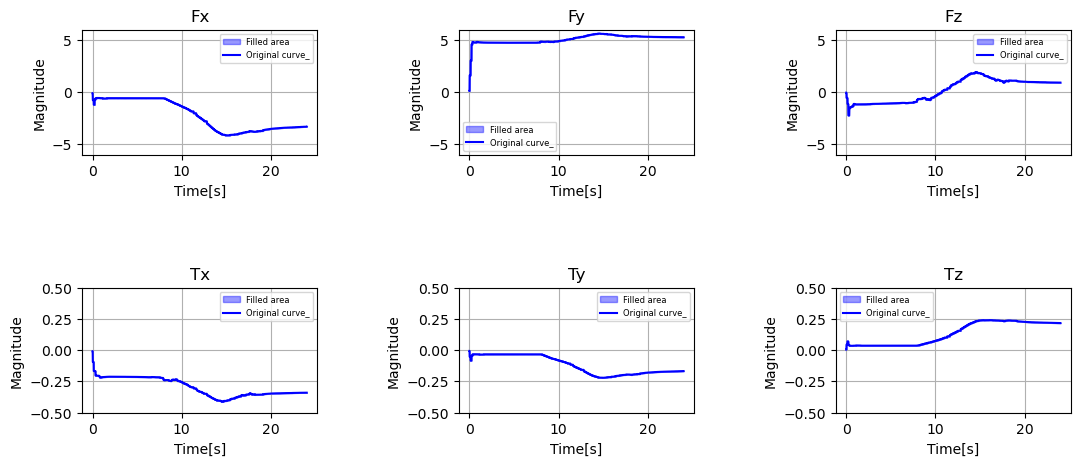

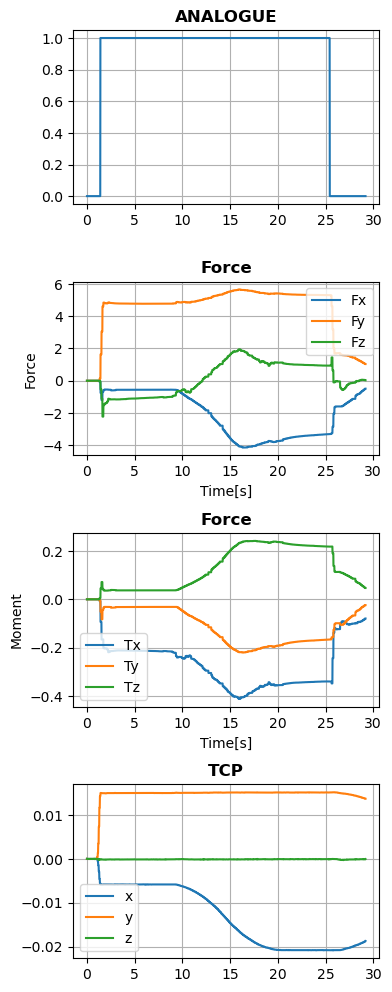

In [19]:
## DATA 1
path='./csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로 
Desired_param=[[1],[0],[0],[1]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME1=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
full_path_TCP=[new_list[i]+'/'+A.contents[2] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time1,TOTAL1,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)
#TCP_1= tcp_moving_range(full_path_TCP)
plotting_SINGLE('h',Time1,TOTAL1,NAME_LABEL,False)
plot_everything(A)

In [166]:
TCP_1

[[6.739926227000001, 36.319870881]]

In [17]:
## Plotting
def plot_everything(DATAFORMATTED_DATA):
    initial_off=True
    j=1
    pad_a=1
    plt.figure(figsize=(4,10))
    for i in range(len(A.contents)): # file list
        if A.contents[i]=='Force':    
            df = pd.read_csv(new_list[0]+'/'+A.contents[i],names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])

            if initial_off==True:
                off_Fx=df['Fx'][0]
                off_Fy=df['Fy'][0]
                off_Fz=df['Fz'][0]
                off_Tx=df['Tx'][0]
                off_Ty=df['Ty'][0]
                off_Tz=df['Tz'][0]
            else:
                off_Fx=0
                off_Fy=0
                off_Fz=0
                off_Tx=0
                off_Ty=0
                off_Tz=0


            plt.subplot(4,1,j)
            j=j+1
            plt.plot(df['Time']*pow(10,-9),df['Fx']-off_Fx,df['Time']*pow(10,-9),df['Fy']-off_Fy,df['Time']*pow(10,-9),df['Fz']-off_Fz)
            plt.xlabel("Time[s]")
            plt.ylabel("Force")
            plt.grid()
            plt.title(A.contents[i],fontsize=12,fontweight="bold")
            #plt.vlines(x = TCP_1[0],ymin = -4, ymax = 4,color = 'black',linewidth = 1, linestyle ="--")

            plt.tight_layout(pad=pad_a)
            plt.legend(['Fx','Fy','Fz'])

            #plt.ylim((-5, 5))
            plt.subplot(4,1,j)
            j=j+1
            plt.plot(df['Time']*pow(10,-9),df['Tx']- off_Tx,df['Time']*pow(10,-9),df['Ty']- off_Ty,df['Time']*pow(10,-9),df['Tz']- off_Tz)
            plt.xlabel("Time[s]")
            plt.ylabel("Moment")
            plt.grid()
            plt.title(A.contents[i],fontsize=12,fontweight="bold")
            plt.legend(['Tx','Ty','Tz'])
            #plt.ylim((-0.3, 0.3))

            plt.tight_layout(pad=pad_a)
            #plt.show()
            #plt.subplot(2,1,2)
            #plt.plot(df['Time']*pow(10,-9),df['Tx'])



        if A.contents[i]=='TCP':
            df = pd.read_csv(new_list[0]+'/'+A.contents[i],names=['Time','X','Y','Z'])
            '''
            if initial_off==True:
                off_x=df['X'][0]
                off_y=df['Y'][0]
                off_z=df['Z'][0]

            else:
                off_x=0
                off_y=0
                off_z=0'''
            off_x=df['X'][0]
            off_y=df['Y'][0]
            off_z=df['Z'][0]
            plt.subplot(4,1,j)
            j=j+1
            plt.plot(df['Time']*pow(10,-9),df['X']-off_x,df['Time']*pow(10,-9),df['Y']-off_y,df['Time']*pow(10,-9),df['Z']-off_z)
            plt.grid()
            plt.title(A.contents[i],fontsize=12,fontweight="bold")

            plt.legend(['x','y','z'])
            plt.tight_layout(pad=pad_a)

        if A.contents[i]=='ANALOGUE':
            df = pd.read_csv(new_list[0]+'/'+A.contents[i],names=['Time','A0','A1'])


            plt.subplot(4,1,j)
            j=j+1
            plt.plot(df['Time']*pow(10,-9),df['A0'])
            plt.grid()
            plt.title(A.contents[i],fontsize=12,fontweight="bold")
            plt.tight_layout(pad=pad_a)


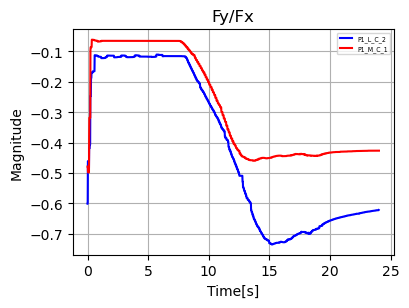

1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_L_C_2', './csv_files/P1_L_C_3']
1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_M_C_1', './csv_files/P1_M_C_2', './csv_files/P1_M_C_3']


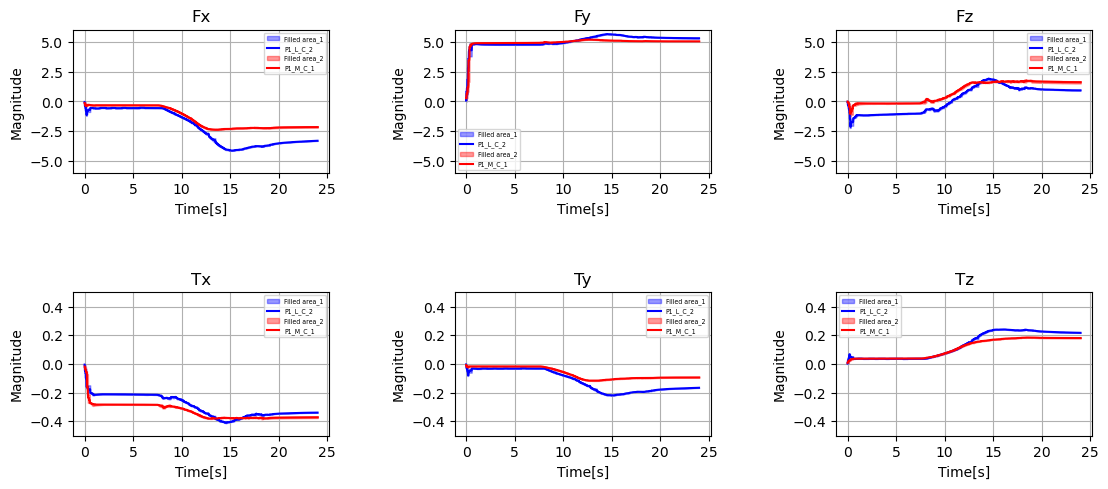

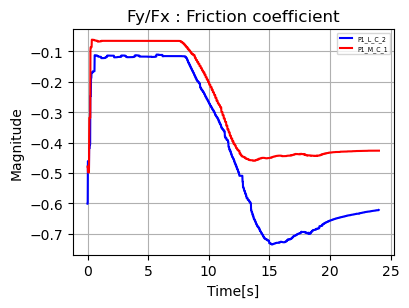

In [284]:
## DATA DOUBLE
path='./csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로 
TOPIC= '1Bar Different contact area'

## DATA 1
Desired_param=[[1],[0],[0],[1,2]]
initial_off=True
A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME1=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
full_path_TCP=[new_list[i]+'/'+A.contents[2] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time1,TOTAL1,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)
#TCP_1= tcp_moving_range(full_path_TCP)

Desired_param=[[1],[1],[0],[0,1,2]]
initial_off=True

               
A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME2=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
full_path_TCP=[new_list[i]+'/'+A.contents[2] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time2,TOTAL2,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)
#TCP_2= tcp_moving_range(full_path_TCP)
plotting_DOUBLE(TOPIC,Time1,TOTAL1,Time2,TOTAL2,DATA_NAME1,DATA_NAME2,NAME_LABEL,True)
plotting_DOUBLE_FRICTION(TOPIC,Time1,TOTAL1,Time2,TOTAL2,DATA_NAME1,DATA_NAME2,NAME_LABEL,True)

1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_L_C_2', './csv_files/P1_L_C_3']
1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_L_d_1', './csv_files/P1_L_d_2', './csv_files/P1_L_d_3']
1st Folder name :  P0.5_L_C_1
Contents in the folder : ['ANALOGUE', 'Force', 'TCP'] 


1 Parameters ['P0.5' 'P1'] 

2 Parameters ['L' 'M'] 

3 Parameters ['C' 'd' 's'] 

4 Parameters ['1' '2' '3'] 

['./csv_files/P1_L_s_1', './csv_files/P1_L_s_2', './csv_files/P1_L_s_3']


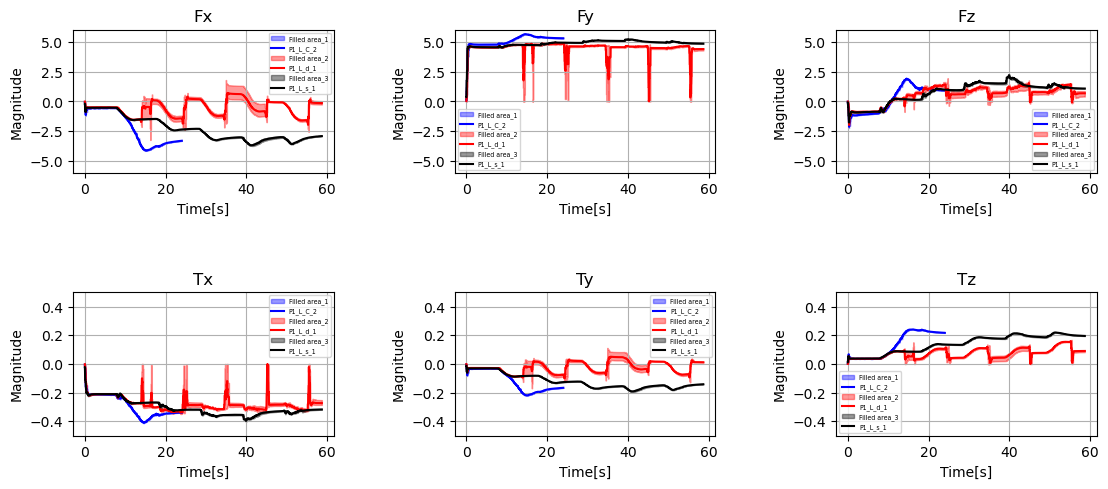

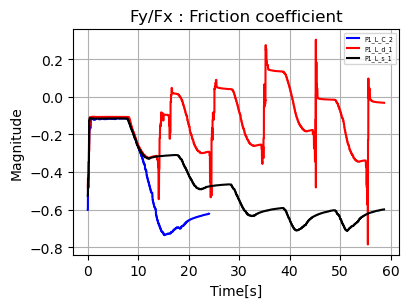

In [21]:
## DATA Tripple
path='./csv_files' # current file directory  /// 파일은 코드가 저장된 위치기준으로 
TOPIC= 'Different moving at 0.5Bar with Large contact_ Friction'

################################################ DATA 1
Desired_param=[[1],[0],[0],[1,2]]

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME1=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time1,TOTAL1,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)

################################################ Data 2
Desired_param=[[1],[0],[1],[0,1,2]]
initial_off=True

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME2=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time2,TOTAL2,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)



#################################################### DATA3
Desired_param=[[1],[0],[2],[0,1,2]]
initial_off=True

A=data_formatter(path,Desired_param)
A.file_searching(path)
A.desired_file_path(Desired_param)
A.Desired_file_directory
new_list=A.Desired_file_directory
print(new_list)
DATA_NAME3=new_list[0][12:]
full_path_ANAL=[new_list[i]+'/'+A.contents[0] for i in range(len(new_list))]
full_path_FORCE=[new_list[i]+'/'+A.contents[1] for i in range(len(new_list))]
Force_INDEX=Find_Force_Index(full_path_FORCE,full_path_ANAL)
Time3,TOTAL3,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)

plotting_TRIPPLE(TOPIC,Time1,TOTAL1,Time2,TOTAL2,Time3,TOTAL3,DATA_NAME1,DATA_NAME2,DATA_NAME3,NAME_LABEL,True)
plotting_TRIPPLE_FRICTION(TOPIC,Time1,TOTAL1,Time2,TOTAL2,Time3,TOTAL3,DATA_NAME1,DATA_NAME2,DATA_NAME3,NAME_LABEL,True)

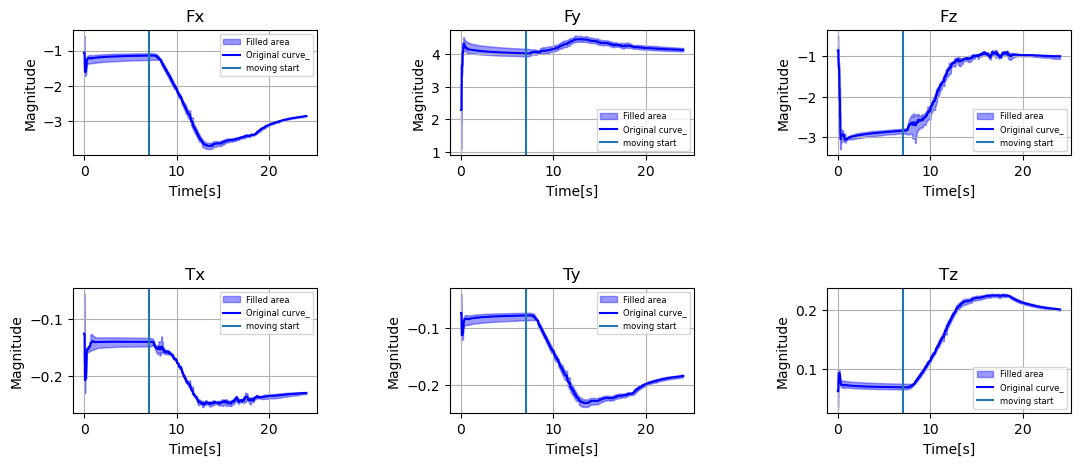

In [78]:
plotting_SINGLE('h',Time1,TOTAL1,NAME_LABEL,False)
#plotting_DOUBLE('Contact area and normal force',Time1,TOTAL1,Time2,TOTAL2,DATA_NAME1,DATA_NAME2,NAME_LABEL,True)
#plotting_TRIPPLE('Movement',Time1,TOTAL1,Time2,TOTAL2,Time3,TOTAL3,DATA_NAME1,DATA_NAME2,DATA_NAME3,NAME_LABEL,True)

In [256]:
Time2,TOTAL2,NAME_LABEL=Force_data_average(full_path_FORCE,Force_INDEX)
len(TOTAL2)

6

In [116]:
[5,5,5,5]-1

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [26]:
def Force_data_average(full_path_FORCE,INFL_INDEX, SLIP_INDEX):
    Fx=[]
    Fy=[]
    Fz=[]
    Tx=[]
    Ty=[]
    Tz=[]
    Slip_point=[]
    for i in range(len(full_path_FORCE)):
        df = pd.read_csv(full_path_FORCE[i],names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])
        range_A=INFL_INDEX[i][0]
        range_B=INFL_INDEX[i][1]

        Fx.append(df['Fx'][range_A:range_B]-df['Fx'][0].tolist())
        Fy.append(df['Fy'][range_A:range_B]-df['Fy'][0].tolist())
        Fz.append(df['Fz'][range_A:range_B]-df['Fz'][0].tolist())
        Tx.append(df['Tx'][range_A:range_B]-df['Tx'][0].tolist())
        Ty.append(df['Ty'][range_A:range_B]-df['Ty'][0].tolist())
        Tz.append(df['Tz'][range_A:range_B]-df['Tz'][0].tolist())

    for j in range(len(SLIP_INDEX[-1])):
        Slip_point.append(df['Time'][SLIP_INDEX[-1][j]]-df['Time'][range_A])
    Time=(df['Time'][range_A:range_B]-df['Time'][range_A]).to_numpy()
    ## FORCE
    Fx_min_values = np.min(np.array(Fx), axis=0)
    Fx_max_values = np.max(np.array(Fx), axis=0)
    Fx_mean_values = np.mean(np.array(Fx), axis=0)
    TOTAL_FX=[Fx_min_values,Fx_max_values,Fx_mean_values]

    Fy_min_values = np.min(np.array(Fy), axis=0)
    Fy_max_values = np.max(np.array(Fy), axis=0)
    Fy_mean_values = np.mean(np.array(Fy), axis=0)
    TOTAL_FY=[Fy_min_values,Fy_max_values,Fy_mean_values]

    Fz_min_values = np.min(np.array(Fz), axis=0)
    Fz_max_values = np.max(np.array(Fz), axis=0)
    Fz_mean_values = np.mean(np.array(Fz), axis=0)
    TOTAL_FZ=[Fz_min_values,Fz_max_values,Fz_mean_values]

    ## TORQUE
    Tx_min_values = np.min(np.array(Tx), axis=0)
    Tx_max_values = np.max(np.array(Tx), axis=0)
    Tx_mean_values = np.mean(np.array(Tx), axis=0)
    TOTAL_TX=[Tx_min_values,Tx_max_values,Tx_mean_values]

    Ty_min_values = np.min(np.array(Ty), axis=0)
    Ty_max_values = np.max(np.array(Ty), axis=0)
    Ty_mean_values = np.mean(np.array(Ty), axis=0)
    TOTAL_TY=[Ty_min_values,Ty_max_values,Ty_mean_values]

    Tz_min_values = np.min(np.array(Tz), axis=0)
    Tz_max_values = np.max(np.array(Tz), axis=0)
    Tz_mean_values = np.mean(np.array(Tz), axis=0)
    TOTAL_TZ=[Tz_min_values,Tz_max_values,Tz_mean_values]
    TOTAL=[TOTAL_FX,TOTAL_FY,TOTAL_FZ,TOTAL_TX,TOTAL_TY,TOTAL_TZ]
    NAME_LABEL=['Fx','Fy','Fz','Tx','Ty','Tz']
    return Time,TOTAL, NAME_LABEL,Slip_point

def plotting_SINGLE(save_name,Time,TOTAL, NAME_LABEL,save_fig):
    '''
    Arag
    '''
    plt.figure(figsize=(12,8))
    for i in range(len(TOTAL)): # file list
        plt.subplot(3,3,i+1)
        plt.fill_between(Time*pow(10,-9), TOTAL[i][1], TOTAL[i][0], alpha=0.4, color='blue', label='Filled area')
        plt.plot(Time*pow(10,-9), TOTAL[i][2], label='Original curve_', color='blue')
        #plt.vlines(x = TCP[0],ymin = -4, ymax = 4,color = 'black',linewidth = 1, linestyle ="--")
        #plt.plot(Time*pow(10,-9), TOTAL[i][1], label='Original curve'+NAME_LABEL[i], color='yellow')
        #plt.plot(Time*pow(10,-9), TOTAL[i][0], label='Original curve'+NAME_LABEL[i], color='black')
        #plt.plot(Time, TOTAL[i][0], TOTAL[i][1], alpha=0.3, color='yellow', label='Filled area')
        plt.xlabel('Time[s]')
  
        if i<3:# force
            a=6
            plt.ylim((-a, a))
        else:# Torque
            a=0.5
            plt.ylim((-a, a))
        #plt.vlines(x = TCP[0],ymin = -a, ymax = a,color = 'black',linewidth = 1, linestyle ="--")

        plt.ylabel('Magnitude')
        plt.grid()
        plt.title(NAME_LABEL[i])
        plt.legend(fontsize="6")
        plt.tight_layout(pad=5)
    if save_fig==True:
        plt.savefig(save_name+'.png')

def plotting_DOUBLE(save_name,Time1,TOTAL1,Time2,TOTAL2,DATA_NAME1,DATA_NAME2,NAME_LABEL,save_fig):
    plt.figure(figsize=(12,8))
    for i in range(len(TOTAL1)): # file list
        plt.subplot(3,3,i+1)
        plt.fill_between(Time1*pow(10,-9), TOTAL1[i][1], TOTAL1[i][0], alpha=0.4, color='blue', label='Filled area_1')
        plt.plot(Time1*pow(10,-9), TOTAL1[i][2], label=DATA_NAME1, color='blue')
        plt.fill_between(Time2*pow(10,-9), TOTAL2[i][1], TOTAL2[i][0], alpha=0.4, color='red', label='Filled area_2')
        plt.plot(Time2*pow(10,-9), TOTAL2[i][2], label=DATA_NAME2, color='red')
        #plt.plot(Time*pow(10,-9), TOTAL[i][1], label='Original curve'+NAME_LABEL[i], color='yellow')
        #plt.plot(Time*pow(10,-9), TOTAL[i][0], label='Original curve'+NAME_LABEL[i], color='black')
        #plt.plot(Time, TOTAL[i][0], TOTAL[i][1], alpha=0.3, color='yellow', label='Filled area')
        plt.xlabel('Time[s]')
        
        if i<3:# force
            a=6
            plt.ylim((-a, a))
            #plt.vlines(x = TCP_1.append(TCP_2),ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--")
            
        else:# Torque
            a=0.5
            plt.ylim((-a, a))
            #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--",label='1')
            #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'red',linewidth = 1, linestyle ="--",label='2')

            
            
        
        plt.ylabel('Magnitude')
        plt.grid()
        plt.title(NAME_LABEL[i])
        plt.legend(fontsize="4.5")
        plt.tight_layout(pad=4)

    if save_fig==True:
        plt.savefig(save_name+'.png') 

def plotting_DOUBLE_FRICTION(save_name,Time1,TOTAL1,Time2,TOTAL2,DATA_NAME1,DATA_NAME2,NAME_LABEL,save_fig):
    plt.figure(figsize=(5,4)) 
    plt.plot(Time1*pow(10,-9), TOTAL1[0][2]/TOTAL1[1][2], label=DATA_NAME1, color='blue')
    plt.plot(Time2*pow(10,-9), TOTAL2[0][2]/TOTAL2[1][2], label=DATA_NAME2, color='red')
        #plt.plot(Time*pow(10,-9), TOTAL[i][1], label='Original curve'+NAME_LABEL[i], color='yellow')
        #plt.plot(Time*pow(10,-9), TOTAL[i][0], label='Original curve'+NAME_LABEL[i], color='black')
        #plt.plot(Time, TOTAL[i][0], TOTAL[i][1], alpha=0.3, color='yellow', label='Filled area')
    plt.xlabel('Time[s]')
    '''
    if i<3:# force
        a=6
        plt.ylim((-a, a))
        #plt.vlines(x = TCP_1.append(TCP_2),ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--")

    else:# Torque
        a=0.5
        plt.ylim((-a, a))
        #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--",label='1')
        #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'red',linewidth = 1, linestyle ="--",label='2')
    '''
            
            
        
    plt.ylabel('Magnitude')
    plt.grid()
    plt.title('Fy/Fx : Friction coefficient')
    plt.legend(fontsize="4.5")
    plt.tight_layout(pad=4)
    if save_fig==True:
        plt.savefig(save_name+'_Friction'+'.png') 
        
def plotting_TRIPPLE(save_name,Time1,TOTAL1,Time2,TOTAL2,Time3,TOTAL3,DATA_NAME1,DATA_NAME2,DATA_NAME3,NAME_LABEL,save_fig):
    plt.figure(figsize=(12,8))
    for i in range(len(TOTAL1)): # file list
        plt.subplot(3,3,i+1)
        plt.fill_between(Time1*pow(10,-9), TOTAL1[i][1], TOTAL1[i][0], alpha=0.4, color='blue', label='Filled area_1')
        plt.plot(Time1*pow(10,-9), TOTAL1[i][2], label=DATA_NAME1, color='blue')
        plt.fill_between(Time2*pow(10,-9), TOTAL2[i][1], TOTAL2[i][0], alpha=0.4, color='red', label='Filled area_2')
        plt.plot(Time2*pow(10,-9), TOTAL2[i][2], label=DATA_NAME2, color='red')
        plt.fill_between(Time3*pow(10,-9), TOTAL3[i][1], TOTAL3[i][0], alpha=0.4, color='black', label='Filled area_3')
        plt.plot(Time3*pow(10,-9), TOTAL3[i][2], label=DATA_NAME3, color='black')
        #plt.plot(Time*pow(10,-9), TOTAL[i][1], label='Original curve'+NAME_LABEL[i], color='yellow')
        #plt.plot(Time*pow(10,-9), TOTAL[i][0], label='Original curve'+NAME_LABEL[i], color='black')
        #plt.plot(Time, TOTAL[i][0], TOTAL[i][1], alpha=0.3, color='yellow', label='Filled area')
        plt.xlabel('Time[s]')
        if i<3:# force
            plt.ylim((-6, 6))
        else:# Torque
            plt.ylim((-0.5, 0.5))
        plt.ylabel('Magnitude')
        plt.grid()
        plt.title(NAME_LABEL[i])
        plt.legend(fontsize="4.5")
        plt.tight_layout(pad=4)
    if save_fig==True:
        plt.savefig(save_name+'.png')

def plotting_TRIPPLE_FRICTION(save_name,Time1,TOTAL1,Time2,TOTAL2,Time3,TOTAL3,DATA_NAME1,DATA_NAME2,DATA_NAME3,NAME_LABEL,save_fig):
    plt.figure(figsize=(5,4)) 
    plt.plot(Time1*pow(10,-9), TOTAL1[0][2]/TOTAL1[1][2], label=DATA_NAME1, color='blue')
    plt.plot(Time2*pow(10,-9), TOTAL2[0][2]/TOTAL2[1][2], label=DATA_NAME2, color='red')
    plt.plot(Time3*pow(10,-9), TOTAL3[0][2]/TOTAL3[1][2], label=DATA_NAME3, color='black')
        #plt.plot(Time*pow(10,-9), TOTAL[i][1], label='Original curve'+NAME_LABEL[i], color='yellow')
        #plt.plot(Time*pow(10,-9), TOTAL[i][0], label='Original curve'+NAME_LABEL[i], color='black')
        #plt.plot(Time, TOTAL[i][0], TOTAL[i][1], alpha=0.3, color='yellow', label='Filled area')
    plt.xlabel('Time[s]')
    '''
    if i<3:# force
        a=6
        plt.ylim((-a, a))
        #plt.vlines(x = TCP_1.append(TCP_2),ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--")

    else:# Torque
        a=0.5
        plt.ylim((-a, a))
        #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'blue',linewidth = 1, linestyle ="--",label='1')
        #plt.vlines(x = TCP_1,ymin = -a, ymax = a,color = 'red',linewidth = 1, linestyle ="--",label='2')
    '''
            
            
        
    plt.ylabel('Magnitude')
    plt.grid()
    plt.title('Fy/Fx : Friction coefficient')
    plt.legend(fontsize="4.5")
    plt.tight_layout(pad=4)
    if save_fig==True:
        plt.savefig(save_name+'_Friction'+'.png') 

In [4]:
def Find_Force_Index(path_direcotry_whole_file_list_FORCE,path_direcotry_whole_file_list_ANALOGUE):
    T_val_list=Find_Time_Range(path_direcotry_whole_file_list_ANALOGUE)
    F_val_index_list=[]
    for i in range(len(path_direcotry_whole_file_list_FORCE)):
        df_force_np=pd.read_csv(path_direcotry_whole_file_list_FORCE[i],header=None)[0].to_numpy()
        if i==0:
            Force_1=np.argmin(abs(df_force_np-T_val_list[i][0]))
            Force_2=np.argmin(abs(df_force_np-T_val_list[i][1]))
            Stride=Force_2-Force_1
        else:
            Force_1=np.argmin(abs(df_force_np-T_val_list[i][0]))
        F_val_index_list.append([Force_1,Force_1+Stride])
    result=F_val_index_list
    return result 

def Find_Time_Range(path_direcotry_whole_file_list_ANALOGUE):
    time_range=[]
    for i in range(len(path_direcotry_whole_file_list_ANALOGUE)):
        df=pd.read_csv(path_direcotry_whole_file_list_ANALOGUE[i],header=None)
        time_range.append([df[0][Find_range(path_direcotry_whole_file_list_ANALOGUE)[i][0]],df[0][Find_range(path_direcotry_whole_file_list_ANALOGUE)[i][1]]])
    return time_range

def Find_range(path_direcotry_whole_file_list):
    '''
    ARG : Wanted file list + 
    OUTPUT : Find range for each file
    '''
    range_index=[]
    diff_index=[]
    for i in range(len(path_direcotry_whole_file_list)):
        file_path_for_range=path_direcotry_whole_file_list[i]
        range_index.append(find_change_points(file_path_for_range))
        diff_index.append(find_change_points(file_path_for_range)[1]-find_change_points(file_path_for_range)[0])
    if check_all_same(diff_index):
        result=range_index
    else:
        print(f'Difference in indexing for each file{diff_index}')
        result='Find range Fail'
    return result
def check_all_same(lst):# check up all the same value in the list(find the check point
    return all(element == lst[0] for element in lst)
def find_change_points(file_path): # find the change point
    '''
    Arg: analogue file path => To find specific change point
    Output : Two values(start => end)
    '''
    df = pd.read_csv(file_path,header=None)
    index_of_changes = []
    previous_value = None

    for index, row in df.iterrows():
        current_value = row[1]

        if current_value != previous_value:
            index_of_changes.append(index)
    
        previous_value = current_value
    if len(index_of_changes)==3:
        results=index_of_changes[1:3]
    else:
        results=index_of_changes[1:3]
        print(f'Find_change_points wrong. The change point should be 2points including 0, but it has {results} ')
        results="THE VALUE IS WRONG"
    return results
    
    

In [377]:
index_of_changes = []
previous_value = None

for index, row in df.iterrows():
    current_value = row[1]
    
    if current_value != previous_value:
        index_of_changes.append(index)
    
    previous_value = current_value

print(index_of_changes[:])


[0, 358, 3362]


In [386]:
index_of_changes[1:3]

[358, 3362]

In [268]:
## Averaging

def Averaging(Multi_trial_file_directory_list):
    for i in range(len(Multi_trial_file_directory_list)):
        if i ==1:
            df= pd.read_csv(Multi_trial_file_directory_list, header=None)
            for j in range(df_mean.shape[1])
                

        else:
            df_temp= pd.read_csv(Multi_trial_file_directory_list, header=None)
            for j in range(df_mean.shape[1])
                
                
'''
Input : Give the file set
Output :
- Min value
- Mean Value
- Max Value
- each column
'''

'\nInput : Give the file set\nOutput :\n- Min value\n- Mean Value\n- Max Value\n- each column\n'

In [314]:
df = pd.read_csv(path+'/'+new_list[1]+'/'+A.contents[1],header=None)
AA=df.to_numpy()
AA[1]
#df.iloc[:,0].add(df.iloc[:,1])

array([ 8.04985600e+06, -2.57897377e-02, -4.35000658e-02, -3.75928760e-01,
       -2.34313635e-03,  3.51238996e-04, -4.67371196e-04])

In [329]:
df = pd.read_csv(path+'/'+new_list[1]+'/'+A.contents[1],header=None)
ddf = pd.read_csv(path+'/'+new_list[0]+'/'+A.contents[1],header=None)

,0,1,2,3,4,5,6
0,0,-0.028756,-0.042971,-0.354976,-0.002563,0.000169,-0.000267
1,8042032,-0.028756,-0.042971,-0.354976,-0.002563,0.000169,-0.000267
2,16119777,-0.028756,-0.042971,-0.354976,-0.002563,0.000169,-0.000267
3,24227208,-0.028756,-0.042971,-0.354976,-0.002563,0.000169,-0.000267
4,32252759,-0.028756,-0.042971,-0.354976,-0.002563,0.000169,-0.000267
...,...,...,...,...,...,...,...
5908,47828093372,0.282088,0.863482,-0.707825,-0.056266,0.019380,0.001163
5909,47836238673,0.282088,0.863482,-0.707825,-0.056266,0.019380,0.001163
5910,47844242398,0.282088,0.863482,-0.707825,-0.056266,0.019380,0.001163
5911,47852305824,0.282088,0.863482,-0.707825,-0.056266,0.019380,0.001163


In [338]:
## Later
def dat_to_num(df):    
    B=[]
    for i in range(df.shape[1]):
        temp=df[i].values
        B.append(temp)
    return B

C=dat_to_num(df)
CC=dat_to_num(ddf)
len(C[1])
len(CC[1])


5913

In [259]:
dff = pd.read_csv(path+'/'+new_list[0]+'/'+A.contents[1])
type(dff)

pandas.core.frame.DataFrame

In [546]:
df[0][1:4]

1     8049856
2    16202919
3    24282756
Name: 0, dtype: int64

In [8]:

initial_off=False

['./csv_files/P1_L_C_2', './csv_files/P1_L_C_3']

NameError: name 'TCP_1' is not defined

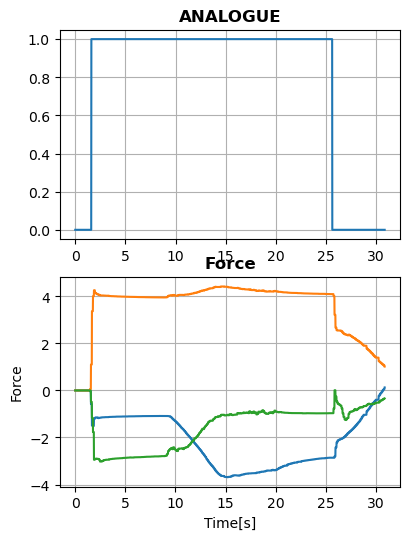

In [136]:
## Plotting
initial_off=True
j=1
pad_a=1
plt.figure(figsize=(4,10))
for i in range(len(A.contents)): # file list
    if A.contents[i]=='Force':    
        df = pd.read_csv(new_list[1]+'/'+A.contents[i],names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])
        
        if initial_off==True:
            off_Fx=df['Fx'][0]
            off_Fy=df['Fy'][0]
            off_Fz=df['Fz'][0]
            off_Tx=df['Tx'][0]
            off_Ty=df['Ty'][0]
            off_Tz=df['Tz'][0]
        else:
            off_Fx=0
            off_Fy=0
            off_Fz=0
            off_Tx=0
            off_Ty=0
            off_Tz=0


        plt.subplot(4,1,j)
        j=j+1
        plt.plot(df['Time']*pow(10,-9),df['Fx']-off_Fx,df['Time']*pow(10,-9),df['Fy']-off_Fy,df['Time']*pow(10,-9),df['Fz']-off_Fz)
        plt.xlabel("Time[s]")
        plt.ylabel("Force")
        plt.grid()
        plt.title(A.contents[i],fontsize=12,fontweight="bold")
        plt.axvline(x = [TCP_1[0]])
        plt.tight_layout(pad=pad_a)
        plt.legend(['Fx','Fy','Fz'])
      
        #plt.ylim((-5, 5))
        plt.subplot(4,1,j)
        j=j+1
        plt.plot(df['Time']*pow(10,-9),df['Tx']- off_Tx,df['Time']*pow(10,-9),df['Ty']- off_Ty,df['Time']*pow(10,-9),df['Tz']- off_Tz)
        plt.xlabel("Time[s]")
        plt.ylabel("Moment")
        plt.grid()
        plt.title(A.contents[i],fontsize=12,fontweight="bold")
        plt.legend(['Tx','Ty','Tz'])
        #plt.ylim((-0.3, 0.3))

        plt.tight_layout(pad=pad_a)
        #plt.show()
        #plt.subplot(2,1,2)
        #plt.plot(df['Time']*pow(10,-9),df['Tx'])



    if A.contents[i]=='TCP':
        df = pd.read_csv(new_list[1]+'/'+A.contents[i],names=['Time','X','Y','Z'])
        '''
        if initial_off==True:
            off_x=df['X'][0]
            off_y=df['Y'][0]
            off_z=df['Z'][0]

        else:
            off_x=0
            off_y=0
            off_z=0'''
        off_x=df['X'][0]
        off_y=df['Y'][0]
        off_z=df['Z'][0]
        plt.subplot(4,1,j)
        j=j+1
        plt.plot(df['Time']*pow(10,-9),df['X']-off_x,df['Time']*pow(10,-9),df['Y']-off_y,df['Time']*pow(10,-9),df['Z']-off_z)
        plt.grid()
        plt.title(A.contents[i],fontsize=12,fontweight="bold")
        plt.legend(['x','y','z'])
        plt.tight_layout(pad=pad_a)
        
    if A.contents[i]=='ANALOGUE':
        df = pd.read_csv(new_list[1]+'/'+A.contents[i],names=['Time','A0','A1'])
        

        plt.subplot(4,1,j)
        j=j+1
        plt.plot(df['Time']*pow(10,-9),df['A0'])
        plt.grid()
        plt.title(A.contents[i],fontsize=12,fontweight="bold")
        plt.tight_layout(pad=pad_a)
    

In [567]:

Time=[]
Fx=[]
Fy=[]
Fz=[]
Tx=[]
Ty=[]
Tz=[]

for i in range(3): 
    df = pd.read_csv(path+'/'+new_list[i]+'/Force',header=None)
    Time.append([df[0].to_numpy()])
    Fx.append([df[1].to_numpy()])
    Fy.append([df[2].to_numpy()])
    Fz.append([df[3].to_numpy()])
    Tx.append([df[4].to_numpy()])
    Ty.append([df[5].to_numpy()])
    Tz.append([df[6].to_numpy()])
    
    
### make min, max 

3

C:\Users\hoons\AppData\Local\Temp\ipykernel_17028\2290997680.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


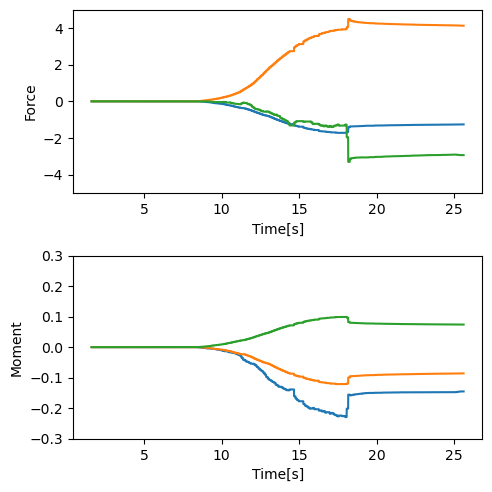

C:\Users\hoons\AppData\Local\Temp\ipykernel_17028\2290997680.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


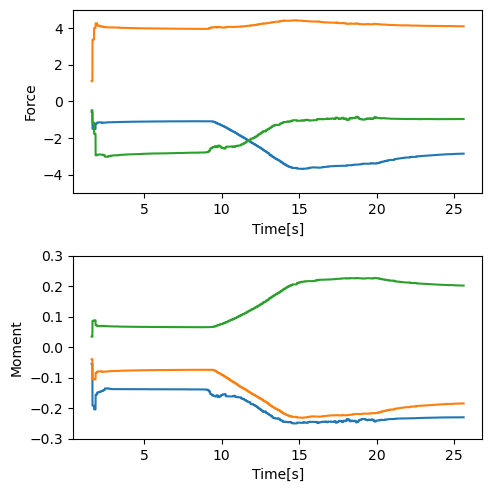

C:\Users\hoons\AppData\Local\Temp\ipykernel_17028\2290997680.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


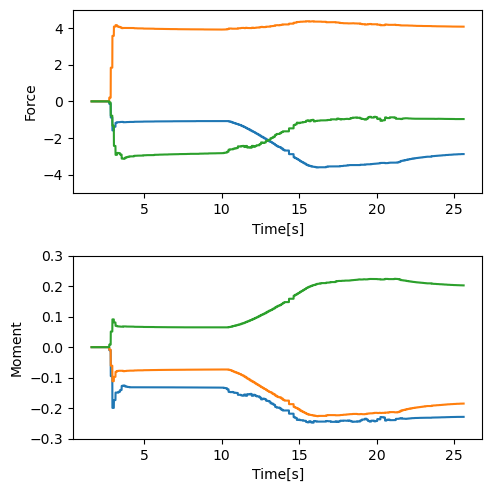

In [553]:
## Plotting

for i in range(3): # file list
    plt.figure(i,figsize=(5,5))
    for j in range(len(A.contents)): # contents list       
        if A.contents[j]=='Force':    
            df = pd.read_csv(path+'/'+new_list[i]+'/'+A.contents[j],names=['Time','Fx','Fy','Fz','Tx','Ty','Tz'])
            plt.title(new_list[i]+'    '+A.contents[j],fontsize=15,fontweight="bold")
            if initial_off==True:
                off_Fx=df['Fx'][0]
                off_Fy=df['Fy'][0]
                off_Fz=df['Fz'][0]
                off_Tx=df['Tx'][0]
                off_Ty=df['Ty'][0]
                off_Tz=df['Tz'][0]
            else:
                off_Fx=0
                off_Fy=0
                off_Fz=0
                off_Tx=0
                off_Ty=0
                off_Tz=0

            Start_F=Force_INDEX[j][0]
            End_F=Force_INDEX[j][1]

            plt.subplot(2,1,1)
            plt.plot(df['Time'][Start_F:End_F]*pow(10,-9),df['Fx'][Start_F:End_F]-off_Fx,df['Time'][Start_F:End_F]*pow(10,-9),df['Fy'][Start_F:End_F]-off_Fy,df['Time'][Start_F:End_F]*pow(10,-9),df['Fz'][Start_F:End_F]-off_Fz)
            plt.xlabel("Time[s]")
            plt.ylabel("Force")
            plt.ylim((-5, 5))
            plt.subplot(2,1,2)
            plt.plot(df['Time'][Start_F:End_F]*pow(10,-9),df['Tx'][Start_F:End_F]- off_Tx,df['Time'][Start_F:End_F]*pow(10,-9),df['Ty'][Start_F:End_F]- off_Ty,df['Time'][Start_F:End_F]*pow(10,-9),df['Tz'][Start_F:End_F]- off_Tz)
            plt.xlabel("Time[s]")
            plt.ylabel("Moment")
            plt.ylim((-0.3, 0.3))

            plt.tight_layout(pad=1.0)
            plt.show()
            #plt.subplot(2,1,2)
            #plt.plot(df['Time']*pow(10,-9),df['Tx'])


        
        

    

In [231]:
df['Fx'][0]

-0.028755784034729

In [212]:
A.contents[1]

'Force'

In [9]:
len(Par[1])

2

In [ ]:
a=[]
P=[]
for file in file_directory:
    a.append(file.split('_'))

In [ ]:
aa=pd.DataFrame(a)
len(a[1])

In [ ]:
file_directory

In [ ]:
## Get the file list and path

# path=os.getcwd() # get the current address
# path = "./" # get the current address
'''
path_list = os.listdir(os.getcwd()) # listdir : listing the all files in the directory
for filename in path_list:
    if os.path.splitext(filename)[1]=='':
        print(os.path.splitext(filename)[0])'''







read csv file
and plot the whole data
find the indices
plot the certain range

def find_boolean_change_indices(lst):
    indices =[]
    for i in range(len(lst) - 1):
        if lst[i] != lst[i + 1]:
            indices.append(i + 1)
    return indices

change_indices = find_boolean_change_indices(boolean_list)